In [879]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from tqdm import tqdm

R = 0.0083145  # kJ/(mol*K)
T = 298  # K

solvent_dict = {
#     'Acetat': ('CC(=O)[O-]', 'Acetate'),
    'Acetic-acid': ('CC(=O)O', 'Acetic acid', 6.15, 'small acid'),
    'Aceton': ('CC(=O)C', 'Acetone', 20.7, 'polar aprotic'),
    'Acetonitrile': ('CC#N', 'Acetonitrile', 37.5, 'polar aprotic'),
    'Ammonia': ('N', 'Ammonia', 16.61, 'polar aprotic'),
#     'Ammonium': ('[NH4+]', 'Ammonium', 7.1), #ammonium chloride - solid phase. Will adjust with solution conc. 
    'Benzene': ('c1ccccc1', 'Benzene', 2.28, 'nonpolar'),
#     'Benzoat': ('[O-]C(=O)c1ccccc1', 'Benzoate'),
    'Benzylacetat': ('CC(=O)OCc1ccccc1', 'Benzyl acetate', 5.34, 'polar aprotic'),
    'Butanon': ('CCC(=O)C', 'Butanone', 18.85, 'polar aprotic'),
#     'Chloride': ('[Cl-]', 'Chloride', 7.1), #ammonium chloride - solid phase. Will adjust with solution conc.
    'Chloroform': ('C(Cl)(Cl)Cl', 'Chloroform', 4.8, 'nonpolar'),
    'Cyclohexan': ('C1CCCCC1', 'Cyclohexane', 2.02, 'nonpolar'),
    'Di-2-butylamin': ('CC[C@H](C)N[C@H](C)CC', 'Di-2-butylamine', 4.71, 'nonpolar'),
    'Dichlormethan': ('C(Cl)Cl', 'Dichloromethane', 8.93, 'polar aprotic'),
    'Diethanolamin': ('OCCNCCO', 'Diethanolamine', 25.75, 'polar protic'),
#     'Diethanolammonium': ('OCC[NH2+]CCO', 'Diethanolammonium'),
#     'Diethylenamin': ('CCNCC', 'Diethylamine', 3.8, 'nonpolar'), #Average of three sources - 3.6, 3.8, 3.92 all reported.
#     'Diethylenammonium': ('CC[NH2+]CC', 'Diethylenammonium'),
    'Diethylether': ('CCOCC', 'Diethylether',4.33, 'nonpolar'),
    'Dioctylether': ('CCCCCCCCOCCCCCCC', 'Dioctylether', 2, 'nonpolar'), #Estimate
    'DMA': ('CC(=O)N(C)C', 'DMA', 37.8, 'polar aprotic'),
    'DMF': ('CN(C)C=O', 'DMF', 36.7, 'polar aprotic'),
    'DMSO': ('CS(=O)C', 'DMSO', 46.7, 'polar aprotic'),
    'EC': ('C1COC(=O)O1', 'EC', 89.78, 'polar aprotic'),
    'EMC': ('CCOC(=O)OC', 'EMC', 2.99, 'nonpolar'),
    'Ethanol': ('CCO', 'Ethanol', 24.55, 'polar protic'),
    'Ethylacetat': ('CCOC(=O)C', 'Ethyl acetate', 6.02, 'polar aprotic'),
#     'Ethylenamin': ('C=CN', 'Ethylenamine', 6.94, 'polar protic'),
#     'Ethylenammonium': ('CC[NH3+]', 'Ethylenammonium'),
    'Ethylenglykol': ('OCCO', 'Ethylene glycol', 37.0, 'polar protic'),
#     'Formiat': ('C(=O)[O-]', 'Formate'),
    'Formic-acid': ('O=CO', 'Formic acid', 51.1, 'small acid'),
    'g-Butyrolacton': ('O=C1CCCO1', 'γ-Butyrolactone', 41.68, 'polar aprotic'),
    'Glycerin': ('OCC(O)CO', 'Glycerol', 46.5, 'polar protic'),
    'H2O': ('O', 'Water', 80.1, 'water'),
    'H2SO4': ('O=S(=O)(O)O', 'Sulfuric acid', 100, 'small acid'), #Lots of varying reports 21.9, 100, 84, 80, 106. Chosen 100 for now.
    'Hexafluorbenzol': ('Fc1c(F)c(F)c(F)c(F)c1F', 'Hexafluorobenzene',  2.05, 'nonpolar'),
    'Isooctane': ('CC(C)CC(C)(C)C', 'Isooctane', 1.94, 'nonpolar'),
    'Isopropanol': ('CC(O)C', 'Isopropanol', 17.9, 'polar protic'),
#     'Methanolat': ('C[O-]', 'Methanolate'),
    'n-Hexan': ('CCCCCC', 'n-Hexane', 1.88, 'nonpolar'),
    'Nonandecanol': ('CCCCCCCCCCCCCCCCCCCO', 'Nonandecanol', 3.82, 'fatty alcohol'),
    'Octanol': ('CCCCCCCCO', 'Octanol', 10.3, 'fatty alcohol'),
    'o-Dichlorbenzol': ('Clc1ccccc1Cl', 'o-Dichlorobenzene', 9.93, 'nonpolar'),
#     'Oleic-methyl-ester': ('CCCCCCCCC=CCCCCCCCC(=O)OC', 'Oleic methyl ester', 3.21, 'nonpolar'),
    'Perfluoro-hexan': ('C(C(C(C(F)(F)F)(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)F', 'Perfluorohexane', 1.57, 'nonpolar'),
    'Propylenglykol': ('C[C@@H](O)CO', 'Propylene glycol', 32.0, 'polar protic'),
#     'Tetraethylenammonium': ('CC[N+](CC)(CC)CC', 'Tetraethylenammonium'),
    'THF': ('O1CCCC1', 'THF', 7.58, 'polar aprotic'),
    'Toluol': ('Cc1ccccc1', 'Toluene', 2.38, 'nonpolar'),
    'Tributylphosphat': ('O=P(OCCCC)(OCCCC)OCCCC', 'Tributyl phosphate', 8.29, 'polar aprotic'),
    'Triethanolamin': ('OCCN(CCO)CCO', 'Triethanolamine', 28.11, 'polar protic'),
#     'Triethanolammonium': ('OCC[NH+](CCO)CCO', 'Triethanolammonium'),
#     'Triethylenamin': ('CCN(CC)CC', 'Triethylamine', 2.42, 'nonpolar'),
#     'Triethylenammonium': ('CC[NH+](CC)CC', 'Triethylammonium'),
    'Triglyme': ('COCCOCCOCCOC', 'Triglyme', 7.50, 'polar aprotic'),
    'Urea': ('NC(N)=O', 'Urea', 2.9, 'urea'),
}

# https://www.engineeringtoolbox.com/liquid-dielectric-constants-d_1263.html
# https://people.chem.umass.edu/xray/solvent.html
# https://depts.washington.edu/eooptic/linkfiles/dielectric_chart%5B1%5D.pdf

solvent_keys = list(solvent_dict.keys())
solvent_smiles = list(zip(*solvent_dict.values()))[0]
solvent_names = list(zip(*solvent_dict.values()))[1]
dielctric_constants = list(zip(*solvent_dict.values()))[2]
solvent_classes = list(zip(*solvent_dict.values()))[3]
solvent_class_dict = {s:c for s,c in zip(solvent_names, solvent_classes)}
dielectric_dict = {s:e for s,e in zip(solvent_keys, dielctric_constants)}
dielectric_name_dict = {s:e for s,e in zip(solvent_names, dielctric_constants)}
solvent_key_name_dict = {k:n for k,n in zip(solvent_keys, solvent_names)}
# smiles_to_names_dict = {k:v for k,v in zip(solvents, solvent_names)}
# solvent_class_dict = {v[1]:v[3] for k,v in solvent_dict.items()}
# solvent_class_order = ['nonpolar', 'fatty alcohol', 'polar aprotic', 'polar protic', 'small acid', 'urea', 'water']

In [889]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns


def lower_triangular_heatmap(data, col_labels, row_labels, hide_diags=False, annot_fmt=".0f",
                             cbar_title="% Agreement", annot_size=12):
    
    if hide_diags:
        col_labels = col_labels[:-1]
        row_labels = [""] + row_labels[1:]

    mask = np.zeros_like(data, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = hide_diags

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(24, 24))

    # Generate a custom diverging colormap
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
#     cmap = sns.diverging_palette(10, 220, as_cmap=True)
    cmap = sns.diverging_palette(20, 220, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(data, mask=mask, cmap=cmap, annot=True,  fmt=annot_fmt,
                           yticklabels=row_labels, xticklabels=col_labels, annot_kws=dict(size=annot_size),
                           square=True, linewidths=.5, cbar_kws=dict(shrink=.6, pad=-0.1))

    # rotate bottom tick labels
    ax.set_xticklabels(ax.get_xticklabels(),rotation=-40,ha="left",rotation_mode='anchor')
    
    # colorbar font/tick sizes and label
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    ax.figure.axes[-1].yaxis.label.set_size(12)
    cbar.ax.set_title(cbar_title, fontsize=16, pad=30)
    
    # tick sizes
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)
    
    
def calculate_logp(mol_id):
    
    mol_df = data_df[data_df["mol_id"]==mol_id]

    water_df = mol_df[mol_df["solvent"]=="H2O"]
    octanol_df = mol_df[mol_df["solvent"]=="Octanol"]

    water_bf = np.exp(-water_df['dG(solution)'] / (R*T)) / np.exp(-water_df['dG(solution)'] / (R*T)).sum()
    octanol_bf = np.exp(-octanol_df['dG(solution)'] / (R*T)) / np.exp(-octanol_df['dG(solution)'] / (R*T)).sum()

    dG_solv_water = (water_df['G(solvation)'] * water_bf).sum()
    dG_solv_octanol = (octanol_df['G(solvation)'] * octanol_bf).sum()

    return (dG_solv_water - dG_solv_octanol) / (R*T*np.log(10)) - 0.8224635

In [3]:
coords_df = pd.read_pickle("../data/debug/dft_coords.pkl.gz")

In [4]:
data_df = pd.read_pickle("../data/debug/free_energy.pkl.gz")
data_df = data_df[data_df['solvent'].isin(solvent_keys)]

# convert everything to kcal/mol
numeric_columns = ['dE(gas)', 'dG(gas)', 'dG(solution)', 'E(gas)',
                   'G(gas)', 'G(solution)', 'G(solvation)', 'G(RRHO)']
data_df[numeric_columns] = data_df[numeric_columns] * 0.239006

# define some additional columns
data_df['G(gas+solvation)'] = data_df['E(gas)'] + data_df['G(solvation)']
data_df['G(gas+RRHO)'] = data_df['E(gas)'] + data_df['G(RRHO)']

pd.set_option('display.max_rows', 20)
data_df

,mol_id,conf_id,solvent,dE(gas),dG(gas),dG(solution),E(gas),G(gas),G(solution),G(solvation),G(RRHO),G(gas+solvation),G(gas+RRHO)
5,molecule_16112,conf00008,Acetic-acid,0.000000,0.000000,0.000000,-598051.061777,-597962.628840,-597967.876217,-5.247138,88.432698,-598056.308915,-597962.629079
6,molecule_16112,conf00002,Acetic-acid,0.032505,0.032983,0.026291,-598051.029272,-597962.595857,-597967.849926,-5.254069,88.433415,-598056.283341,-597962.595857
7,molecule_16112,conf00007,Acetic-acid,0.022706,0.027725,0.322658,-598051.039072,-597962.601355,-597967.553559,-4.952204,88.437717,-598055.991276,-597962.601355
8,molecule_16112,conf00009,Acetic-acid,0.053059,0.493069,0.479446,-598051.008718,-597962.135771,-597967.396771,-5.260761,88.872947,-598056.269479,-597962.135771
9,molecule_16112,conf00006,Acetic-acid,0.635517,0.584609,0.499284,-598050.426260,-597962.044232,-597967.376933,-5.332463,88.381790,-598055.758723,-597962.044471
...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,molecule_112040377,conf00014,Urea,3.245462,3.216782,1.864247,-773045.761663,-772987.027851,-772996.800806,-9.773194,58.733812,-773055.534858,-772987.027851
724,molecule_112040377,conf00009,Urea,2.082220,2.052823,2.059754,-773046.924906,-772988.191571,-772996.605299,-8.413728,58.733334,-773055.338634,-772988.191571
725,molecule_112040377,conf00003,Urea,3.222279,3.213675,2.127631,-773045.784847,-772987.030719,-772996.537661,-9.506942,58.754128,-773055.291789,-772987.030719
726,molecule_112040377,conf00018,Urea,4.103972,3.853016,2.280356,-773044.903154,-772986.391378,-772996.384697,-9.993319,58.511776,-773054.896473,-772986.391378


In [5]:
pd.set_option('display.max_rows', 20)
id_to_smi = pd.read_csv("../data/full/id_smiles_all.smi").set_index("ID")
id_to_smi = id_to_smi.groupby(id_to_smi.index).first()
id_to_smi["canon_smi"] = id_to_smi["SMILES"].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
id_to_smi[id_to_smi.index.isin(data_df.mol_id.unique())]

,SMILES,canon_smi
ID,,
ct_ASTXFQ867JZC,COP(=O)(OC)OC1=C(Cl)C2C=CCC12,COP(=O)(OC)OC1=C(Cl)C2C=CCC12
ct_EEDPHDRIILNA,C[C@@H]1CO[C@](C)(c2ccc3c(c2)[Si](C)(C)CC[Si]3...,C[C@@H]1CO[C@](C)(c2ccc3c(c2)[Si](C)(C)CC[Si]3...
ct_GEO9E3ZEJUNS,C[C@@H]1CC[C@@H](C)[Si]1(C)C,C[C@@H]1CC[C@@H](C)[Si]1(C)C
ct_JEZFLES0MXNN,C[SiH]1O[SiH](C)O[SiH](C)O[SiH](C)O[SiH](C)O1,C[SiH]1O[SiH](C)O[SiH](C)O[SiH](C)O[SiH](C)O1
ct_NFJMYG0TMUNN,O=P(Sc1ccccc1)(Sc1ccccc1)Sc1ccccc1,O=P(Sc1ccccc1)(Sc1ccccc1)Sc1ccccc1
...,...,...
pka_extern_5003,c1c[nH]c(P(c2[nH]cc[nH+]2)c2[nH]cc[nH+]2)n1,c1c[nH]c(P(c2[nH]cc[nH+]2)c2[nH]cc[nH+]2)n1
pka_extern_5004,c1c[nH]c(P(c2ncc[nH]2)c2[nH]cc[nH+]2)n1,c1c[nH]c(P(c2ncc[nH]2)c2[nH]cc[nH+]2)n1
pka_extern_5395,O=[P@]([O-])(O)[C@@H]([NH2+]Cc1ccncc1)c1ccccc1O,O=[P@]([O-])(O)[C@@H]([NH2+]Cc1ccncc1)c1ccccc1O


In [45]:
atom_energies = pd.read_pickle("../data/atom_energies.pkl")['bulk']
atom_energies["Al"] = np.nan
atom_energies["Se"] = np.nan
atom_energies["Te"] = np.nan
atom_energies["As"] = np.nan
atom_energies["Sn"] = np.nan
atom_energies

{'B': -64717.371,
 'H': -1296.871,
 'O': -197136.55,
 'Br': -6759077.255,
 'Cl': -1208238.619,
 'S': -1045356.039,
 'Ge': -5453686.178,
 'Si': -759818.658,
 'I': -30010.48,
 'N': -143339.039,
 'F': -261923.107,
 'C': -99367.924,
 'P': -896080.55,
 'Al': nan,
 'Se': nan,
 'Te': nan,
 'As': nan,
 'Sn': nan}

In [41]:
# calculate dE(gas)

data_df["solute_smi"] = id_to_smi.loc[data_df["mol_id"].values]["canon_smi"].values
mol_dict = {smi:Chem.MolFromSmiles(smi) for smi in data_df["solute_smi"].unique()}
ea_dict = {smi:sum([atom_energies[a.GetSymbol()] for a in Chem.AddHs(mol_dict[smi]).GetAtoms()])\
           for smi in data_df["solute_smi"].unique()}

In [35]:
# data_df.apply(lambda x: x["E(gas)"] - ea_dict[x["solute_smi"]], axis=1)
data_df

,mol_id,conf_id,solvent,dE(gas),dG(gas),dG(solution),E(gas),G(gas),G(solution),G(solvation),G(RRHO),G(gas+solvation),G(gas+RRHO),solute_smi
5,molecule_16112,conf00008,Acetic-acid,0.000000,0.000000,0.000000,-598051.061777,-597962.628840,-597967.876217,-5.247138,88.432698,-598056.308915,-597962.629079,F[Si](F)(c1ccccc1)c1ccccc1
6,molecule_16112,conf00002,Acetic-acid,0.032505,0.032983,0.026291,-598051.029272,-597962.595857,-597967.849926,-5.254069,88.433415,-598056.283341,-597962.595857,F[Si](F)(c1ccccc1)c1ccccc1
7,molecule_16112,conf00007,Acetic-acid,0.022706,0.027725,0.322658,-598051.039072,-597962.601355,-597967.553559,-4.952204,88.437717,-598055.991276,-597962.601355,F[Si](F)(c1ccccc1)c1ccccc1
8,molecule_16112,conf00009,Acetic-acid,0.053059,0.493069,0.479446,-598051.008718,-597962.135771,-597967.396771,-5.260761,88.872947,-598056.269479,-597962.135771,F[Si](F)(c1ccccc1)c1ccccc1
9,molecule_16112,conf00006,Acetic-acid,0.635517,0.584609,0.499284,-598050.426260,-597962.044232,-597967.376933,-5.332463,88.381790,-598055.758723,-597962.044471,F[Si](F)(c1ccccc1)c1ccccc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,molecule_112040377,conf00014,Urea,3.245462,3.216782,1.864247,-773045.761663,-772987.027851,-772996.800806,-9.773194,58.733812,-773055.534858,-772987.027851,NCc1nc(-c2cncs2)cs1
724,molecule_112040377,conf00009,Urea,2.082220,2.052823,2.059754,-773046.924906,-772988.191571,-772996.605299,-8.413728,58.733334,-773055.338634,-772988.191571,NCc1nc(-c2cncs2)cs1
725,molecule_112040377,conf00003,Urea,3.222279,3.213675,2.127631,-773045.784847,-772987.030719,-772996.537661,-9.506942,58.754128,-773055.291789,-772987.030719,NCc1nc(-c2cncs2)cs1
726,molecule_112040377,conf00018,Urea,4.103972,3.853016,2.280356,-773044.903154,-772986.391378,-772996.384697,-9.993319,58.511776,-773054.896473,-772986.391378,NCc1nc(-c2cncs2)cs1


In [50]:
-2489048.6699999995--598051.061777

-1890997.6082229996

In [42]:
ea_dict

{'F[Si](F)(c1ccccc1)c1ccccc1': -2489048.6699999995,
 'Fc1c(F)c(F)c2c(c1F)C1C3C4C2C25CC=CCC12C3C45': -2851877.511999999,
 'Cc1ccncc1C(=O)NCC1(O)CCCC(C)(C)CC1': -2403924.531999996,
 'CCn1cc(C(=O)N2CCCc3ccnc(N(C)C)c32)cn1': -2530952.8199999966,
 'CCCC[C@H]1N[C@@H](C(C)C)N(C[C@@H](C)N2CCCC2)C1=O': -2359205.117999994,
 'CCn1cc(/C=C/C(=O)OC)cn1': -1590824.9460000005,
 'COCCn1cc(C(=O)OC2CCS(=O)(=O)C2)c2ccccc21': -3788905.160999997,
 'Cc1ccc(CNC2=NCCC2)cc1': -1499843.102000001,
 'CNC1CCC(Nc2cnnn2C)CC1': -1735014.9840000009,
 'COc1ccc(C(=O)Nc2cccc(-c3csc(C)n3)c2)c(OC)c1': -3834778.000999998,
 'C[C@H](c1cccs1)N(C)C(=O)c1n[nH]cc1N': -2927052.1029999973,
 'F[B-](F)(F)[NH2+]c1cccc2cccc([NH2+][B-](F)(F)F)c12': -2994299.4119999986,
 'C[C@H]1CN(C(=O)Nc2ccc(C(=O)O)nc2)C[C@@H]1C': -2335256.5859999973,
 'COc1ccc(Br)cc1C1C(C#N)=C(C)NC(C)=C1C#N': -8994273.899999991,
 'Oc1cccc(Cl)c1': -2008067.0680000002,
 'CC(C)(C)C1=Nc2ccccc2[Si]1(C)C': -2219581.2579999967,
 'C=CCn1c(Cc2c[nH]c3ccccc23)nnc1SCC(=O)Nc1ccc(C)

In [ ]:
mol_id = avail_mol_ids[12]
print(mol_id)
smi = id_to_smi.loc[mol_id].SMILES

mol = Chem.MolFromSmiles(smi)


### logP validation

In [992]:
logp_df = pd.read_csv("../data/ulrich_logP_pred_soln.csv")
logp_df

,mol_id,smiles,n confs,logP (exp),logP (pred),"logP (pred, one conf, gas)","logP (pred, one conf, water)","logP (pred, one conf, octanol)","logP (pred, one conf, water/octanol)","logP (pred, error cancel, water)","logP (pred, error cancel, octanol)","logP (pred, error cancel, both)","logP (pred, error cancel, gas)"
0,molecule_85,Brc1ccc(Br)cc1,1,3.79,3.310284,3.310284,3.310284,3.310284,3.310284,3.310284,3.310284,3.310284,3.310284
1,molecule_31210,C#CC,1,0.94,1.045318,1.045318,1.045318,1.045318,1.045318,1.045318,1.045318,1.045318,1.045318
2,molecule_4246,C#CC(C)(C)O,3,0.28,1.057257,1.130329,1.118410,1.118410,1.118410,1.087477,1.107466,1.097471,1.119120
3,molecule_101616139,C#CCCC(C)=O,5,0.58,0.692424,0.897557,0.897557,0.897557,0.897557,0.747136,0.802033,0.774585,0.791134
4,molecule_65842060,C#CCN1C(=O)COc2cc(F)c(N3C(=O)C4=C(CCCC4)C3=O)cc21,3,2.55,3.328203,3.501865,3.164977,3.466634,2.916255,3.365949,3.414001,3.389975,3.449425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,ct_IGBA9LP5NJNN,c1ccc2c(c1)ccc1cc3c(ccc4ccccc43)cc12,1,6.75,5.491291,5.491291,5.491291,5.491291,5.491291,5.491291,5.491291,5.491291,5.491291
361,ct_CTO8EYMCYHNN,c1ccc2c(c1)ccc1sccc12,1,4.41,3.709747,3.709747,3.709747,3.709747,3.709747,3.709747,3.709747,3.709747,3.709747
362,molecule_6361,c1cnc2nccnc2c1,1,-0.04,-0.610024,-0.610024,-0.610024,-0.610024,-0.610024,-0.610024,-0.610024,-0.610024,-0.610024
363,pka_extern_1052,c1cncc([C@@H]2CCCCN2)c1,3,0.97,1.360631,2.041083,1.396404,1.396404,1.396404,1.500512,1.619479,1.559995,1.866671


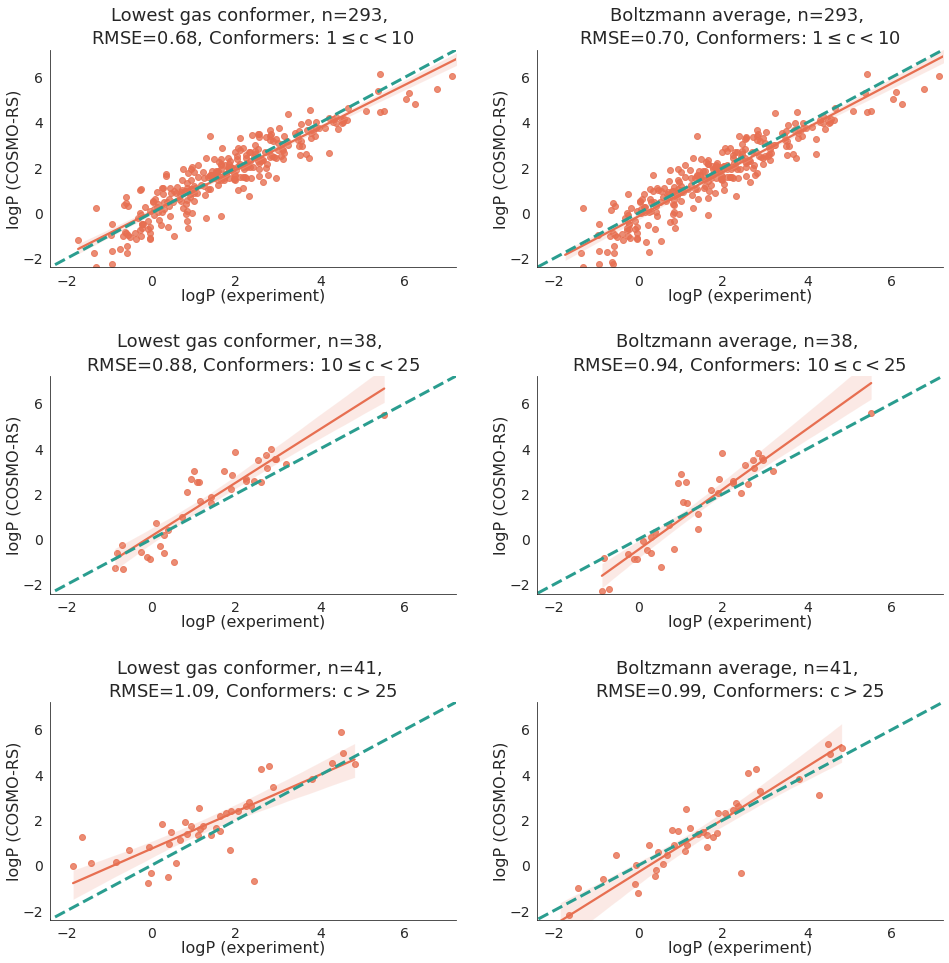

In [997]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
sns.set_style("white")


# palette = ["#eb8d81", "#89aeca", "#aed071", "#b586b6", "#eab36f", "#ecdf78", "#c1bdd7", "#f7d2e5", "#94cac1"]
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

ys = ["logP (pred, one conf, gas)", "logP (pred)"]
titles = ["Lowest gas conformer", "Boltzmann average"]
n_confs_cutoff = [1, 1, 10, 10, 25, 25, 9e99, 9e99]

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    
    logp_df_n = logp_df[(logp_df["n confs"]>=n_confs_cutoff[i]) & (logp_df["n confs"]<=n_confs_cutoff[i+2])]
    
    sns.regplot(
        data=logp_df_n,
        x="logP (exp)",
        y=ys[i%2],
        ax=ax,
        color=palette[4]
    )

    sns.lineplot(
        x=np.arange(-10, 9),
        y=np.arange(-10, 9),
        ax=ax,
        linewidth=3,
        linestyle="--",
        color=palette[1]
    )

    rmse = np.sqrt(np.square(logp_df_n['logP (exp)'] - logp_df_n[ys[i%2]]).mean())

    ax.set_ylim(-2.4, 7.2)
    ax.set_xlim(-2.4, 7.2)

    ax.set_xlabel("logP (experiment)", fontsize=16, labelpad=0)
    ax.set_ylabel("logP (COSMO-RS)", fontsize=16, labelpad=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    if i<4:
        ax.set_title(f"{titles[i%2]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: {n_confs_cutoff[i]}$\leq$c$<${n_confs_cutoff[i+2]}", fontsize=18)
    else:
        ax.set_title(f"{titles[i%2]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: c$>${n_confs_cutoff[i]}", fontsize=18)

    
# plt.savefig("../exps/plots/logp_validation.pdf", bbox_inches="tight")

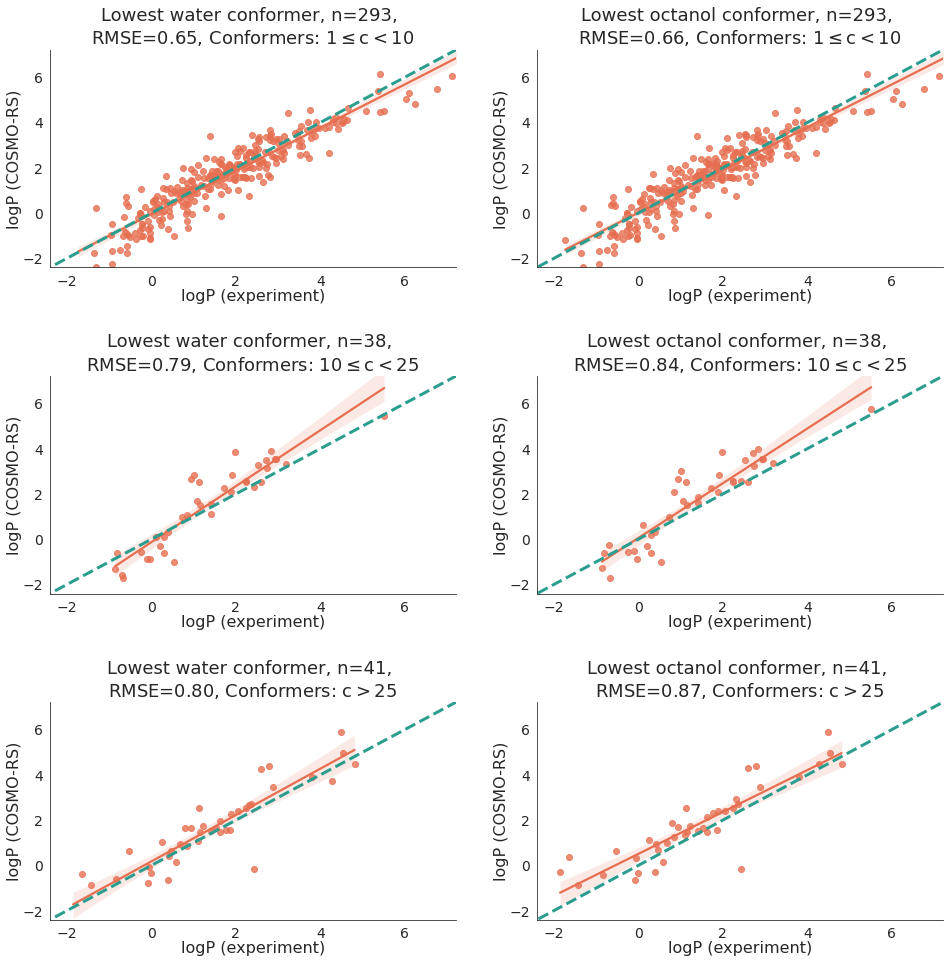

In [998]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
sns.set_style("white")

ys = ["logP (pred, one conf, water)", "logP (pred, one conf, octanol)"]
titles = ["Lowest water conformer", "Lowest octanol conformer"]

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    
    logp_df_n = logp_df[(logp_df["n confs"]>=n_confs_cutoff[i]) & (logp_df["n confs"]<=n_confs_cutoff[i+2])]
    
    sns.regplot(
        data=logp_df_n,
        x="logP (exp)",
        y=ys[i%2],
        ax=ax,
        color=palette[4]
    )

    sns.lineplot(
        x=np.arange(-10, 9),
        y=np.arange(-10, 9),
        ax=ax,
        linewidth=3,
        linestyle="--",
        color=palette[1]
    )

    rmse = np.sqrt(np.square(logp_df_n['logP (exp)'] - logp_df_n[ys[i%2]]).mean())

    ax.set_ylim(-2.4, 7.2)
    ax.set_xlim(-2.4, 7.2)

    ax.set_xlabel("logP (experiment)", fontsize=16, labelpad=0)
    ax.set_ylabel("logP (COSMO-RS)", fontsize=16, labelpad=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    if i<4:
        ax.set_title(f"{titles[i%2]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: {n_confs_cutoff[i]}$\leq$c$<${n_confs_cutoff[i+2]}", fontsize=18)
    else:
        ax.set_title(f"{titles[i%2]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: c$>${n_confs_cutoff[i]}", fontsize=18)

    
# plt.savefig("../exps/plots/logp_validation_ow_confs.pdf", bbox_inches="tight")

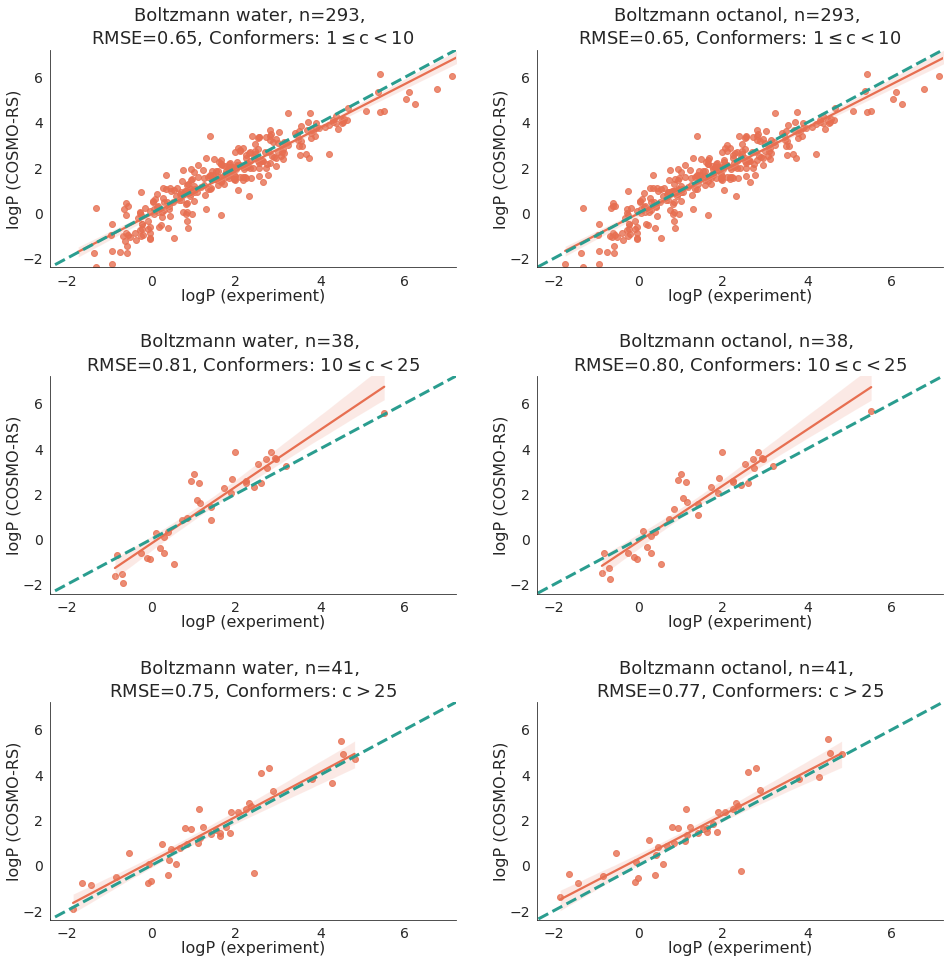

In [999]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
sns.set_style("white")

ys = ["logP (pred, error cancel, water)", "logP (pred, error cancel, both)"]
titles = ["Boltzmann water", "Boltzmann octanol"]

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    
    logp_df_n = logp_df[(logp_df["n confs"]>=n_confs_cutoff[i]) & (logp_df["n confs"]<=n_confs_cutoff[i+2])]
    
    sns.regplot(
        data=logp_df_n,
        x="logP (exp)",
        y=ys[i%2],
        ax=ax,
        color=palette[4]
    )

    sns.lineplot(
        x=np.arange(-10, 9),
        y=np.arange(-10, 9),
        ax=ax,
        linewidth=3,
        linestyle="--",
        color=palette[1]
    )

    rmse = np.sqrt(np.square(logp_df_n['logP (exp)'] - logp_df_n[ys[i%2]]).mean())

    ax.set_ylim(-2.4, 7.2)
    ax.set_xlim(-2.4, 7.2)

    ax.set_xlabel("logP (experiment)", fontsize=16, labelpad=0)
    ax.set_ylabel("logP (COSMO-RS)", fontsize=16, labelpad=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    if i<4:
        ax.set_title(f"{titles[i%2]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: {n_confs_cutoff[i]}$\leq$c$<${n_confs_cutoff[i+2]}", fontsize=18)
    else:
        ax.set_title(f"{titles[i%2]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: c$>${n_confs_cutoff[i]}", fontsize=18)

    
# plt.savefig("../exps/plots/logp_validation_ow_confs.pdf", bbox_inches="tight")

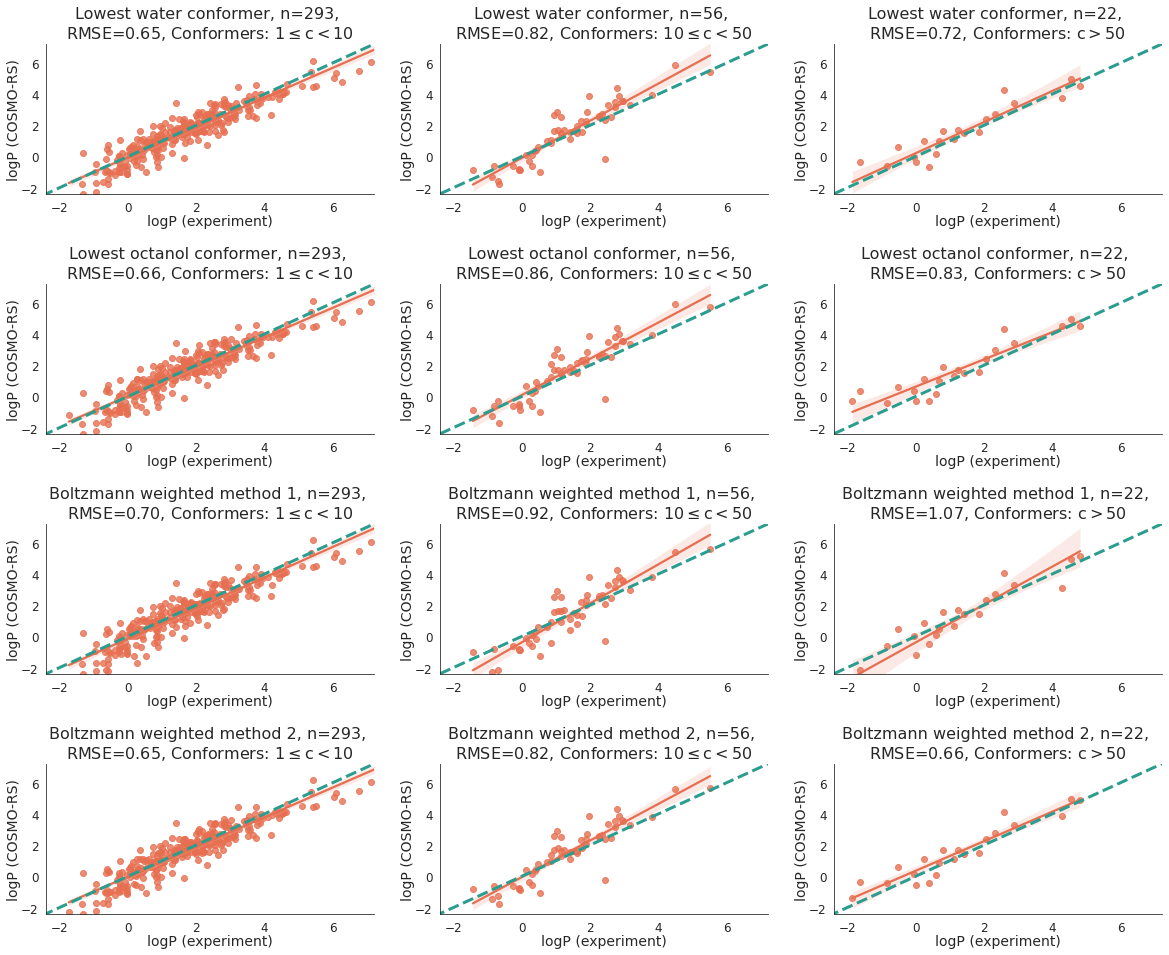

In [1194]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.6)
sns.set_style("white")

palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]
ys = ["logP (pred, one conf, water)", "logP (pred, one conf, octanol)", "logP (pred)", "logP (pred, error cancel, both)"]
titles = ["Lowest water conformer", "Lowest octanol conformer", "Boltzmann weighted method 1", "Boltzmann weighted method 2"]
n_confs_cutoff = [1, 10, 50, 9e99]

for i, ax in enumerate(axes.ravel()):
    
    logp_df_n = logp_df[(logp_df["n confs"]>=n_confs_cutoff[(i+3)%3]) & (logp_df["n confs"]<=n_confs_cutoff[(i+3)%3+1])]
    
    sns.regplot(
        data=logp_df_n,
        x="logP (exp)",
        y=ys[int(np.floor(i/3))],
        ax=ax,
        color=palette[4]
    )

    sns.lineplot(
        x=np.arange(-10, 9),
        y=np.arange(-10, 9),
        ax=ax,
        linewidth=3,
        linestyle="--",
        color=palette[1]
    )

    rmse = np.sqrt(np.square(logp_df_n['logP (exp)'] - logp_df_n[ys[int(np.floor(i/3))]]).mean())

    ax.set_ylim(-2.4, 7.2)
    ax.set_xlim(-2.4, 7.2)

    ax.set_xlabel("logP (experiment)", fontsize=14, labelpad=0)
    ax.set_ylabel("logP (COSMO-RS)", fontsize=14, labelpad=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    if (i+3)%3!=2:
        ax.set_title(f"{titles[int(np.floor(i/3))]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: {n_confs_cutoff[(i+3)%3]}$\leq$c$<${n_confs_cutoff[(i+3)%3+1]}", fontsize=16)
    else:
        ax.set_title(f"{titles[int(np.floor(i/3))]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: c$>${n_confs_cutoff[(i+3)%3]}", fontsize=16)

    
plt.savefig("../exps/plots/logp_validation.pdf", bbox_inches="tight")

In [1199]:
logp_df["water_conf_error"] = np.abs(logp_df["logP (exp)"] - logp_df["logP (pred, one conf, water)"])
logp_df["boltz_avg_cancel_error"] = np.abs(logp_df["logP (exp)"] - logp_df["logP (pred, error cancel, both)"])

In [1211]:
logp_df[logp_df["n confs"]>60].mean()

/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


n confs                                 225.800000
logP (exp)                                1.252500
logP (pred)                               1.118093
logP (pred, one conf, gas)                1.857740
logP (pred, one conf, water)              1.476901
logP (pred, one conf, octanol)            1.768032
logP (pred, one conf, water/octanol)      0.947021
logP (pred, error cancel, water)          1.460650
logP (pred, error cancel, octanol)        1.688113
logP (pred, error cancel, both)           1.574382
logP (pred, error cancel, gas)            1.786626
water_conf_error                          0.581985
boltz_avg_cancel_error                    0.538146
dtype: float64

### dataset conformer analysis

In [1111]:
solvents = data_df.solvent.unique()
n_solvents = len(solvents)
agreement, agreement_counter = np.zeros([len(solvents), len(solvents)]), 0
rrho_agreement, gas_agreement = [], []

dG_solution_dG_solution_pr = np.zeros([len(solvents), len(solvents)])
dE_gas_dG_solution_pr = np.zeros([len(solvents), len(solvents)])
dE_gas_dG_solv_pr = np.zeros([len(solvents), len(solvents)])
dE_gas_dG_rrho_pr = np.zeros([len(solvents), len(solvents)])
spearman_r_counter = 0
threshold = 20

conf_g_correction = []
n_confs_min_for_q = []
n_confs_total = []

partition_factor = 0.95
relative_components_list = []
mol_dfs, conf_dfs = [], []


# build molecule-level and conformer-level dataframes
for mol_id, df in tqdm(data_df.groupby("mol_id")):
    
    # get low energy confs
    low_energy_confs = df[df['dG(solution)']<threshold].conf_id.unique()
    df_low_energy_confs = df[df['conf_id'].isin(low_energy_confs)]
    
    # skip if less than two conformers
    if len(df_low_energy_confs) > (2*len(solvents)):
    
        # lowest energy conformer
        min_conf_soln = df.set_index('conf_id').groupby("solvent")['dG(solution)'].idxmin().sort_index()
        agree = np.array(min_conf_soln.values == min_conf_soln.values[:, None], dtype=int)
        agreement += agree
        agreement_counter += 1

        # does conformer order change after g_solvation and rrho?
        min_conf_gas = df.set_index('conf_id').groupby("solvent")['dE(gas)'].idxmin().sort_index()
        gas_agree = np.array(min_conf_soln.values == min_conf_gas.values, dtype=int)
        gas_agreement.append(gas_agree)       

        # spearman correlation    
        # mutiple columns for "values" will return cross correlations
#         pr = df_low_energy_confs.pivot(index='conf_id', columns='solvent', \
#                                        values=['dE(gas)', 'dG(solution)', 'G(gas+solvation)', 'G(gas+RRHO)']).corr(method='spearman').values
#         dG_solution_dG_solution_pr += pr[1*n_solvents:(1*n_solvents+n_solvents), 1*n_solvents:(1*n_solvents+n_solvents)]
#         dE_gas_dG_solution_pr += pr[0*n_solvents:(0*n_solvents+n_solvents), 1*n_solvents:(1*n_solvents+n_solvents)]
#         dE_gas_dG_solv_pr += pr[0*n_solvents:(0*n_solvents+n_solvents), 2*n_solvents:(2*n_solvents+n_solvents)]
#         dE_gas_dG_rrho_pr += pr[0*n_solvents:(0*n_solvents+n_solvents), 3*n_solvents:(3*n_solvents+n_solvents)]
#         spearman_r_counter += 1
        
        # partition functions
        q_df = df.sort_values(['solvent', 'dG(solution)'])
        q_df['boltzmann_factor_pre'] = np.exp(-q_df['dG(solution)'] / (R*T))
        q_df['boltzmann_factor'] = q_df.groupby('solvent')['boltzmann_factor_pre'].apply(lambda x: \
                                            x / np.sum(x))
#         q_df['boltzmann_factor_cum'] = q_df.groupby('solvent')['boltzmann_factor_pre'].apply(lambda x: \
#                                             np.cumsum(x) / np.cumsum(x).max())
#         n_confs_min = q_df.groupby('solvent')['boltzmann_factor_cum'].apply(lambda x: \
#                                             (x < partition_factor).argmin()+1).values
#         n_confs_total.append(q_df.groupby('solvent')['mol_id'].count().values)
#         n_confs_min_for_q.append(n_confs_min)
        
        ################################
        ###### CONFORMER ANALYSIS ######
        ################################
        
        # distributions of all intermediate quantities (parent dataframe)
        q_df_solv = q_df.groupby("solvent")
        mol_df = q_df_solv[['E(gas)', 'G(solvation)', 'G(RRHO)', 'G(solution)']]\
                           .apply(lambda x: (x - x.min()).max()).reset_index().sort_values('solvent')

        # how much do conformers influence G(solution)
        # ground truth (Boltzmann sum)
        g_soln_all_confs = q_df_solv.apply(lambda x: np.sum(x['G(solution)'] * x['boltzmann_factor'])).sort_index()

        # single LEC in gas phase
        lec_gas = df.set_index('conf_id').groupby("solvent")['E(gas)'].idxmin().sort_index().values[0]
        g_soln_lec_gas = q_df[q_df["conf_id"]==lec_gas].sort_values('solvent').set_index('solvent')['G(solution)']

        # single LEC in gas phase + solvation
        lec_gas_solv = q_df.set_index('conf_id').groupby("solvent")['G(gas+solvation)'].idxmin().sort_index()
        g_soln_lec_gas_solv = q_df.set_index(['solvent', 'conf_id']).loc[zip(lec_gas_solv.index, lec_gas_solv.values)]\
                                                                .droplevel(level='conf_id').sort_index()['G(solution)']

        # boltzmann average using all confs in gas + solv and RRHO for LEC
        rrho_lec_gas_solv = q_df.set_index(['solvent', 'conf_id']).loc[zip(lec_gas_solv.index, lec_gas_solv.values)]\
                                                                .droplevel(level='conf_id').sort_index()['G(RRHO)']
        boltzmann_factors_gas_solv_ = np.exp(-q_df.sort_values('conf_id').groupby('solvent').apply(lambda x: \
                                     (x['E(gas)'] + x['G(solvation)']) - (x['E(gas)'] + x['G(solvation)']).min()) / (R*T))
        boltzmann_factors_gas_solv = boltzmann_factors_gas_solv_ / boltzmann_factors_gas_solv_.groupby('solvent').sum()
        Gsoln_gas_solv = q_df.sort_values('conf_id').groupby('solvent')\
                             .apply(lambda x: x['E(gas)'] + x['G(solvation)'] + \
                                              rrho_lec_gas_solv.loc[x['solvent'].values[0]])
        g_soln_boltz_gas_solv = (Gsoln_gas_solv * boltzmann_factors_gas_solv).groupby('solvent').sum().sort_index()
        
        # single LEC in solution
        g_soln_lec_soln = q_df.set_index(['solvent', 'conf_id']).loc[zip(min_conf_soln.index, min_conf_soln.values)]\
                                                                .droplevel(level='conf_id').sort_index()['G(solution)']

        # differences from ref (should all be sorted by solvent values)
        corr_lec_gas = g_soln_lec_gas - g_soln_all_confs
        corr_lec_gas_solv = g_soln_lec_gas_solv - g_soln_all_confs
        corr_boltz_gas_solv = g_soln_boltz_gas_solv - g_soln_all_confs
        corr_lec_soln = g_soln_lec_soln - g_soln_all_confs
        
        # how many conformers to get within x kcal/mol of true value?
        q_df["G(solution)_contrib"] = q_df_solv.apply(lambda x: (x["boltzmann_factor"] * x["G(solution)"])).values
        q_df["G(solution)_contrib_cum"] = q_df_solv.apply(lambda x: (x["boltzmann_factor"].cumsum() * x["G(solution)"])).values
        q_df["G(solution)_contrib_diff"] = q_df.apply(lambda x: x["G(solution)_contrib_cum"] - g_soln_all_confs.loc[x['solvent']], axis=1).values
        q_df["G(solution)_contrib_factor"] = q_df.apply(lambda x: x["G(solution)_contrib_diff"] / -g_soln_all_confs.loc[x['solvent']], axis=1).values

        # update mol_df
        mol_df["mol_id"] = mol_id
        mol_df["corr_lec_gas"] = corr_lec_gas.values
        mol_df["corr_lec_gas_solv"] = corr_lec_gas_solv.values
        mol_df["corr_boltz_gas_solv"] = corr_boltz_gas_solv.values
        mol_df["corr_lec_soln"] = corr_lec_soln.values
        
        mol_df["corr_lec_gas_abs"] = np.abs(corr_lec_gas.values)
        mol_df["corr_lec_gas_solv_abs"] = np.abs(corr_lec_gas_solv.values)
        mol_df["corr_boltz_gas_solv_abs"] = np.abs(corr_boltz_gas_solv.values)
        mol_df["corr_lec_soln_abs"] = np.abs(corr_lec_soln.values)
        
        mol_df["min_conf_gas"] = min_conf_gas.values
        mol_df["min_conf_solv"] = lec_gas_solv.values
        mol_df["min_conf_soln"] = min_conf_soln.values
        
        # how many conformers needed to get within x kcal/mol of true value
        boltz_factors = q_df_solv.apply(lambda x: np.exp(-x["dG(solution)"]/(R*T))).values.reshape(n_solvents, -1)
        g_solution_conf = q_df["G(solution)"].values.reshape(n_solvents, -1)
        out = np.expand_dims(boltz_factors, -1) / np.expand_dims(boltz_factors.cumsum(axis=1), -2)
        g_corr_soln_change_with_confs = np.expand_dims(g_soln_all_confs.values, -1) - \
                                        (np.triu(out, k=0) * np.expand_dims(g_solution_conf, -1)).sum(axis=1)
        q_df["G(solution)_corr_confs"] = g_corr_soln_change_with_confs.ravel()
        
        # relative components of all important quantities (slow)
        lec_soln_components = q_df.set_index(['solvent', 'conf_id']).loc[zip(min_conf_soln.index, min_conf_soln.values)]\
                          .droplevel(level='conf_id').sort_index()[["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"]]
        relative_components = q_df.apply(lambda x: x[["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"]] - \
                           lec_soln_components.loc[x["solvent"]], axis=1)
        relative_components["solvent"] = q_df["solvent"]
        relative_components["conf_id"] = q_df["conf_id"]
        relative_components["mol_id"] = mol_id
        relative_components_list.append(relative_components)
        
        # update dfs
        mol_dfs.append(mol_df)
        conf_dfs.append(q_df)
    
    
# agreement = agreement/agreement_counter * 100
# gas_agreement = gas_agreement/agreement_counter * 100

# dG_solution_dG_solution_pr = dG_solution_dG_solution_pr/spearman_r_counter
# dE_gas_dG_solution_pr = dE_gas_dG_solution_pr/spearman_r_counter
# dE_gas_dG_solv_pr = dE_gas_dG_solv_pr/spearman_r_counter
# dE_gas_dG_rrho_pr = dE_gas_dG_rrho_pr/spearman_r_counter

mol_df = pd.concat(mol_dfs).reset_index()
conf_df = pd.concat(conf_dfs).reset_index()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2599/2599 [1:19:12<00:00,  1.83s/it]


In [774]:
df_low_energy_confs.pivot(index='conf_id', columns='solvent', \
                               values=['dE(gas)', 'dG(solution)', 'G(gas+solvation)', 'G(gas+RRHO)'])

dE(gas)                                                          \
solvent   Acetic-acid    Aceton Acetonitrile   Ammonia   Benzene Benzylacetat   
conf_id                                                                         
conf00001    1.045412  1.045412     1.045412  1.045412  1.045412     1.045412   
conf00002    1.052821  1.052821     1.052821  1.052821  1.052821     1.052821   
conf00003    0.000000  0.000000     0.000000  0.000000  0.000000     0.000000   
conf00005    6.800438  6.800438     6.800438  6.800438  6.800438     6.800438   
conf00006    7.619989  7.619989     7.619989  7.619989  7.619989     7.619989   
conf00007    6.614969  6.614969     6.614969  6.614969  6.614969     6.614969   
conf00009    4.999767  4.999767     4.999767  4.999767  4.999767     4.999767   

                                                     ...    G(gas+RRHO)  \
solvent     Butanon Chloroform Cyclohexan       DMA  ... Propylenglykol   
conf_id                                              ...                  
conf00001  1.045412   1.045412   1.045412  1.045412  ... -559705.777570   
conf00002  1.052821   1.052821   1.052821  1.052821  ... -559705.774224   
conf00003  0.000000   0.000000   0.000000  0.000000  ... -559705.581824   
conf00005  6.800438   6.800438   6.800438  6.800438  ... -559700.178377   
conf00006  7.619989   7.619989   7.619989  7.619989  ... -559699.005813   
conf00007  6.614969   6.614969   6.614969  6.614969  ... -559700.236216   
conf00009  4.999767   4.999767   4.999767  4.999767  ... -559700.265614   

                                                                         \
solvent              THF         Toluol Tributylphosphat Triethanolamin   
conf_id                                                                   
conf00001 -559705.777570 -559705.777570   -559705.777570 -559705.777570   
conf00002 -559705.774224 -559705.774224   -559705.774224 -559705.774224   
conf00003 -559705.581824 -559705.581824   -559705.581824 -559705.581824   
conf00005 -559700.178377 -559700.178377   -559700.178377 -559700.178377   
conf00006 -559699.005813 -559699.005813   -559699.005813 -559699.005813   
conf00007 -559700.236216 -559700.236216   -559700.236216 -559700.236216   
conf00009 -559700.265614 -559700.265614   -559700.265614 -559700.265614   

                                                                       \
solvent         Triglyme           Urea g-Butyrolacton        n-Hexan   
conf_id                                                                 
conf00001 -559705.777570 -559705.777570 -559705.777570 -559705.777570   
conf00002 -559705.774224 -559705.774224 -559705.774224 -559705.774224   
conf00003 -559705.581824 -559705.581824 -559705.581824 -559705.581824   
conf00005 -559700.178377 -559700.178377 -559700.178377 -559700.178377   
conf00006 -559699.005813 -559699.005813 -559699.005813 -559699.005813   
conf00007 -559700.236216 -559700.236216 -559700.236216 -559700.236216   
conf00009 -559700.265614 -559700.265614 -559700.265614 -559700.265614   

                           
solvent   o-Dichlorbenzol  
conf_id                    
conf00001  -559705.777570  
conf00002  -559705.774224  
conf00003  -559705.581824  
conf00005  -559700.178377  
conf00006  -559699.005813  
conf00007  -559700.236216  
conf00009  -559700.265614  

[7 rows x 168 columns]

In [397]:
mol_df["solute_smi"] = id_to_smi.loc[mol_df["mol_id"].values]["canon_smi"].values
mol_df["mol"] = mol_df["solute_smi"].apply(Chem.MolFromSmiles)

mol_df["n_rotatable_bonds"] = mol_df["mol"].apply(AllChem.CalcNumRotatableBonds)
mol_df["num_rings"] = mol_df["mol"].apply(AllChem.CalcNumRings)
mol_df["n_hbd"] = mol_df["mol"].apply(AllChem.CalcNumHBD)
mol_df["n_hba"] = mol_df["mol"].apply(AllChem.CalcNumHBA)
mol_df["mol_weight"] = mol_df["mol"].apply(AllChem.CalcExactMolWt)

bins = [0, 100, 200, 300, 400, 500 ,600]
mol_df["mol_weight_binned"] = pd.cut(mol_df["mol_weight"], bins)

In [460]:
percent_confs_needed_for_1kcal_gsoln = \
    conf_df.groupby(["mol_id", "solvent"]).apply(lambda x: \
    (np.argmax(x["G(solution)_corr_confs"]<1)+1)/len(x["G(solution)_corr_confs"]))

mol_df = mol_df.sort_values(["mol_id", "solvent"])
mol_df["percent_confs_needed_for_1kcal_gsoln"] = \
    percent_confs_needed_for_1kcal_gsoln.reset_index().sort_values(["mol_id", "solvent"])[0].values * 100.

# percent_confs_needed_for_half_kcal_gsoln = \
#     conf_df.groupby(["mol_id", "solvent"]).apply(lambda x: \
#     (np.argmax(x["G(solution)_corr_confs"]<0.5)+1)/len(x["G(solution)_corr_confs"]))

# mol_df = mol_df.sort_values(["mol_id", "solvent"])
# mol_df["percent_confs_needed_for_half_kcal_gsoln"] = \
#     percent_confs_needed_for_half_kcal_gsoln.reset_index().sort_values(["mol_id", "solvent"])[0].values * 100.

In [870]:
# how do the relevant conformers change between solvents
# use the Jaccard index to quantify difference in relevant conformers

from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import jaccard, pdist, squareform

def determine_conf_inclusion(df, threshold=1):
    group = df["G(solution)_corr_confs"]
    first_conf = np.argmax(group<threshold)+1
    conf_included = [True] * first_conf + [False] * (len(group)-first_conf)
    return pd.Series(conf_included)


# determine which conformers are included in each solvent set of low-energy conformers
out = conf_df.groupby(["mol_id", "solvent"]).apply(lambda x: determine_conf_inclusion(x, threshold=1))
conf_df = conf_df.sort_values(["mol_id", "solvent"])
conf_df["include_conf"] = out.reset_index().sort_values(["mol_id", "solvent"])[0].values

# find jaccard similarity between solvents
jaccard_sim = []
for i, df in conf_df.groupby(["mol_id"]):
    n_confs = df.conf_id.nunique()
    if n_confs < 3:
        continue
#     df = df[df["solvent"].isin(representative_solvents)]
    jaccard_vals = 1 - squareform(pdist(df.pivot(index='conf_id', columns='solvent', values=['include_conf']).T.sort_values('solvent').values, jaccard))
    jaccard_sim.append(jaccard_vals)

In [895]:
df.pivot(index='conf_id', columns='solvent', values=['include_conf']).T.sort_values('solvent')

conf_id                       conf00001  conf00002  conf00003  conf00005  \
             solvent                                                       
include_conf Acetic-acid           True       True       True      False   
             Aceton                True       True       True      False   
             Acetonitrile          True       True       True      False   
             Ammonia               True       True       True      False   
             Benzene               True       True       True      False   
...                                 ...        ...        ...        ...   
             Triglyme              True       True       True      False   
             Urea                  True       True       True      False   
             g-Butyrolacton        True       True       True      False   
             n-Hexan              False       True      False      False   
             o-Dichlorbenzol       True       True       True      False   

conf_id                       conf00006  conf00007  conf00009  
             solvent                                           
include_conf Acetic-acid          False      False      False  
             Aceton               False      False      False  
             Acetonitrile         False      False      False  
             Ammonia              False      False      False  
             Benzene              False      False      False  
...                                 ...        ...        ...  
             Triglyme             False      False      False  
             Urea                 False      False      False  
             g-Butyrolacton       False      False      False  
             n-Hexan              False      False      False  
             o-Dichlorbenzol      False      False      False  

[42 rows x 7 columns]

In [900]:
conf_df

,index,mol_id,conf_id,solvent,dE(gas),dG(gas),dG(solution),E(gas),G(gas),G(solution),...,G(gas+RRHO),solute_smi,boltzmann_factor_pre,boltzmann_factor,G(solution)_contrib,G(solution)_contrib_cum,G(solution)_contrib_diff,G(solution)_contrib_factor,G(solution)_corr_confs,include_conf
0,32,ct_ASTXFQ867JZC,conf00030,Acetic-acid,0.146750,0.018403,0.000000,-911854.092250,-911757.478854,-911766.166723,...,-911757.478854,COP(=O)(OC)OC1=C(Cl)C2C=CCC12,1.000000,0.044407,-40488.880812,-40488.880812,871276.501915,0.955593,0.783995,True
1,33,ct_ASTXFQ867JZC,conf00027,Acetic-acid,0.000000,0.000000,0.019598,-911854.239000,-911757.497258,-911766.147363,...,-911757.497497,COP(=O)(OC)OC1=C(Cl)C2C=CCC12,0.992121,0.044057,-40169.880792,-80658.760744,831106.621983,0.911536,0.774354,False
2,34,ct_ASTXFQ867JZC,conf00033,Acetic-acid,1.072898,1.045412,0.131692,-911853.166102,-911756.451846,-911766.035269,...,-911756.452085,COP(=O)(OC)OC1=C(Cl)C2C=CCC12,0.948237,0.042108,-38393.058126,-119051.808954,792713.573773,0.869427,0.735071,False
3,35,ct_ASTXFQ867JZC,conf00026,Acetic-acid,0.936426,0.880737,0.299236,-911853.302574,-911756.616760,-911765.867726,...,-911756.616760,COP(=O)(OC)OC1=C(Cl)C2C=CCC12,0.886237,0.039355,-35882.747099,-154934.534177,756830.848551,0.830072,0.677154,False
4,36,ct_ASTXFQ867JZC,conf00041,Acetic-acid,1.407028,1.153682,0.340106,-911852.831971,-911756.343576,-911765.826856,...,-911756.343576,COP(=O)(OC)OC1=C(Cl)C2C=CCC12,0.871739,0.038711,-35295.714194,-190230.241426,721535.141301,0.791361,0.633918,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761489,289,pka_extern_7111,conf00003,o-Dichlorbenzol,0.000000,0.195746,1.336761,-559897.973528,-559705.581824,-559711.252242,...,-559705.581824,C[Si](C)(C)OC1CN(C2CCCCC2)C1,0.583033,0.195450,-109395.557033,-483612.657298,76098.907932,0.135961,0.716043,True
8761490,290,pka_extern_7111,conf00007,o-Dichlorbenzol,6.614969,5.541593,5.050914,-559891.358559,-559700.235977,-559707.537850,...,-559700.236216,C[Si](C)(C)OC1CN(C2CCCCC2)C1,0.130220,0.043654,-24433.219920,-508042.667836,51668.897394,0.092313,0.487918,False
8761491,291,pka_extern_7111,conf00005,o-Dichlorbenzol,6.800438,5.599433,5.093935,-559891.173090,-559700.178377,-559707.495067,...,-559700.178377,C[Si](C)(C)OC1CN(C2CCCCC2)C1,0.127978,0.042902,-24012.641874,-532055.270877,27656.294353,0.049412,0.282203,False
8761492,292,pka_extern_7111,conf00009,o-Dichlorbenzol,4.999767,5.511956,6.268171,-559892.973762,-559700.265614,-559706.320592,...,-559700.265614,C[Si](C)(C)OC1CN(C2CCCCC2)C1,0.079674,0.026709,-14949.238761,-547003.393188,12708.172042,0.022705,0.131158,False


In [913]:
# how large is the common set of conformers needed for all solvents?

include_conf_any_df = conf_df.groupby(["mol_id", "conf_id"])["include_conf"].any()

mol_id           conf_id  
ct_ASTXFQ867JZC  conf00001    False
                 conf00002    False
                 conf00003    False
                 conf00004    False
                 conf00005     True
                              ...  
pka_extern_7111  conf00003     True
                 conf00005     True
                 conf00006    False
                 conf00007    False
                 conf00009    False
Name: include_conf, Length: 208607, dtype: bool

/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


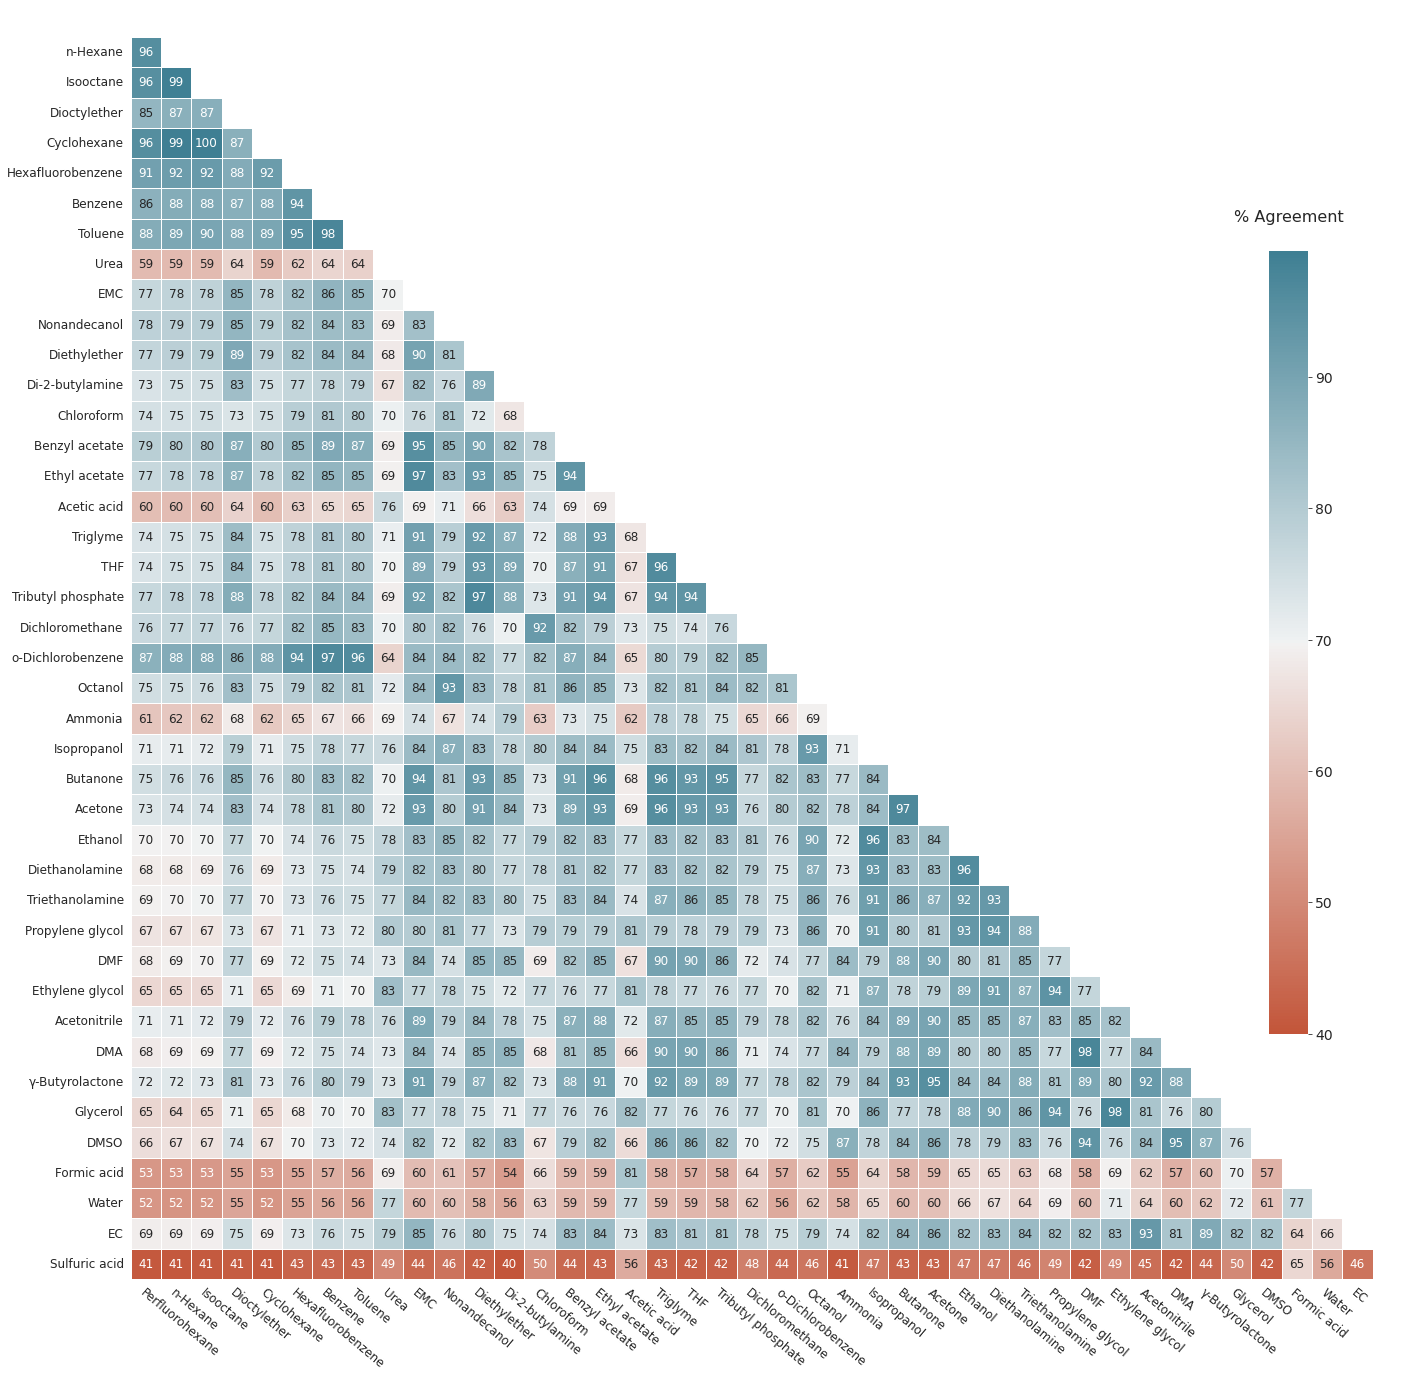

In [891]:
jaccard_sim_solvents = np.stack(jaccard_sim).mean(axis=0) * 100

ordered_dielectric = [dielectric_dict[s] for s in sorted(solvents)]
dielectric_order = np.argsort(ordered_dielectric)
ordered_names = [solvent_key_name_dict[sorted(solvents)[i]] for i in dielectric_order]
reshaped_jaccard_sim_solvents = jaccard_sim_solvents[dielectric_order][:, dielectric_order]

lower_triangular_heatmap(
    reshaped_jaccard_sim_solvents,
    ordered_names,
    ordered_names,
    hide_diags=True,
    annot_fmt=".0f",
)

plt.savefig(f"../exps/plots/jaccard_sim.pdf", bbox_inches="tight")

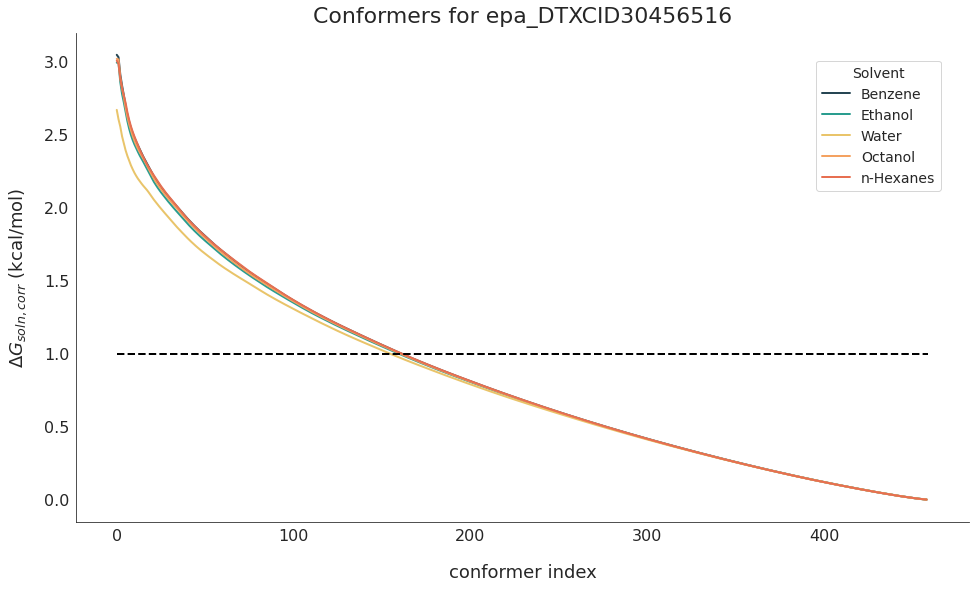

In [881]:
# show an example of conformers considered vs distance from dG corr

from pathlib import Path

# used mols: [-1, -100]

idx = np.argsort([len(x) for x in conf_dfs])[-100]
test_conf_df = conf_dfs[idx]
test_conf_solvents = test_conf_df[test_conf_df["solvent"].isin(representative_solvents)]
mol_id = test_conf_solvents["mol_id"].values[0]
smiles = id_to_smi.loc[mol_id]["canon_smi"]

n_confs = test_conf_solvents["conf_id"].nunique()
test_conf_solvents = test_conf_solvents.sort_values(["solvent", "dG(solution)"])
test_conf_solvents["conf_counter"] = (np.arange(n_confs).tolist() * 5)

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]


sns.lineplot(
    data=test_conf_solvents,
    y="G(solution)_corr_confs",
    x="conf_counter",
    hue='solvent',
    palette=palette,
    linewidth=2,
    ax=ax1
)
ax1.hlines(y=1, xmin=0, xmax=n_confs, color="black", linestyle='--', linewidth=2)

ax1.set_xlabel("conformer index", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=1, fontsize=14, title="Solvent", title_fontsize=14, loc='best', borderaxespad=2,
           labels=["Benzene", "Ethanol", "Water", "Octanol", "n-Hexanes"])
ax1.set_title(f"Conformers for {mol_id}", fontsize=22, pad=10)
#  sorted by increasing $\Delta G_{soln}$

plt_save_path = f"../exps/plots/conf_examples/{mol_id}/{mol_id}_confs.pdf"
if not os.path.exists(Path(plt_save_path).parent.absolute()):
    os.makedirs(Path(plt_save_path).parent.absolute())
plt.savefig(f"../exps/plots/conf_examples/{mol_id}/{mol_id}_confs.pdf", bbox_inches="tight")

In [702]:
# # write mols to file

from rdkit import Chem
# from rdmc import RDKitMol

import tempfile
from shutil import rmtree
from ase import io
import os
from glob import glob

temp_dir = tempfile.mkdtemp()
mol_id = test_conf_solvents["mol_id"].values[0]
test_coords_df = coords_df[coords_df["mol_id"]==mol_id]
conf_ids = test_conf_solvents[test_conf_solvents["solvent"]=="H2O"].sort_values("dG(solution)")["conf_id"].values

for i, m in enumerate(test_coords_df.set_index("conf_id").loc[conf_ids]["mol"]):
    mol_path = os.path.join(temp_dir, f"conf_{i}.xyz")
    io.write(mol_path, m)
    
# confs = []
# for xyz_file in glob(os.path.join(temp_dir, "conf_*")):
#     conf = RDKitMol.FromFile(xyz_file, sameMol=True)
#     confs.append(conf)
    
# ts_path = os.path.join("../../../conf_solv/exps/plots/", f"{mol_id}.sdf")
# ts_writer = Chem.rdmolfiles.SDWriter(ts_path)
# for c in confs:
#     ts_writer.write(c.ToRWMol(), confId=0)

# rmtree(temp_dir)

In [704]:
mol_id

'epa_DTXCID30456516'

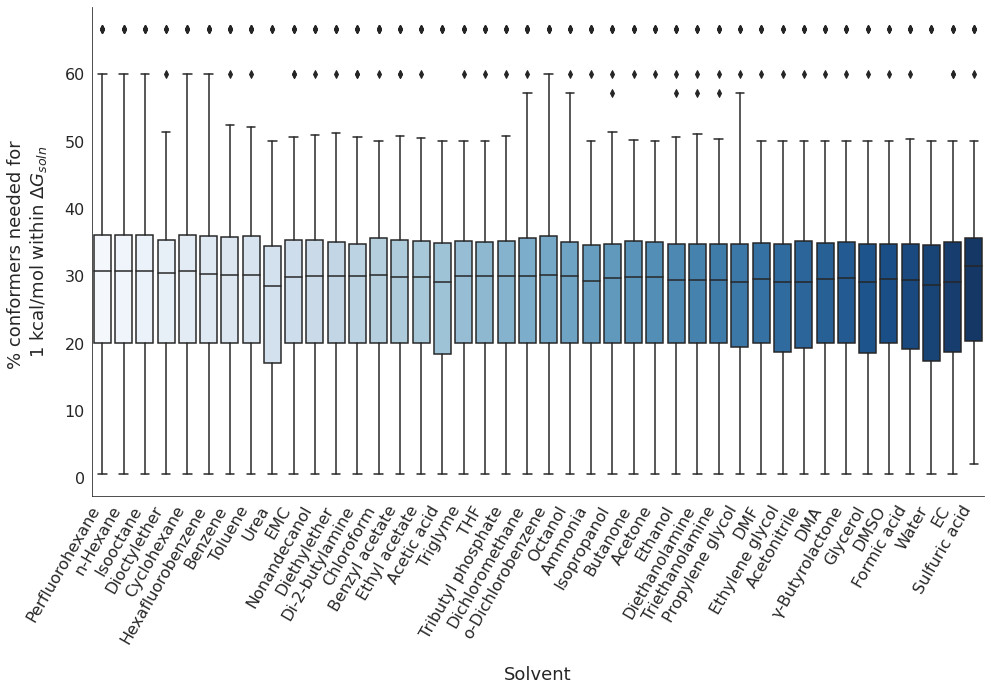

In [562]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=mol_df,
    x='solvent',
    y='percent_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for \n1 kcal/mol within $\Delta G_{soln}$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

plt.savefig("../exps/plots/percent_confs_needed_per_solvent.pdf", bbox_inches="tight")

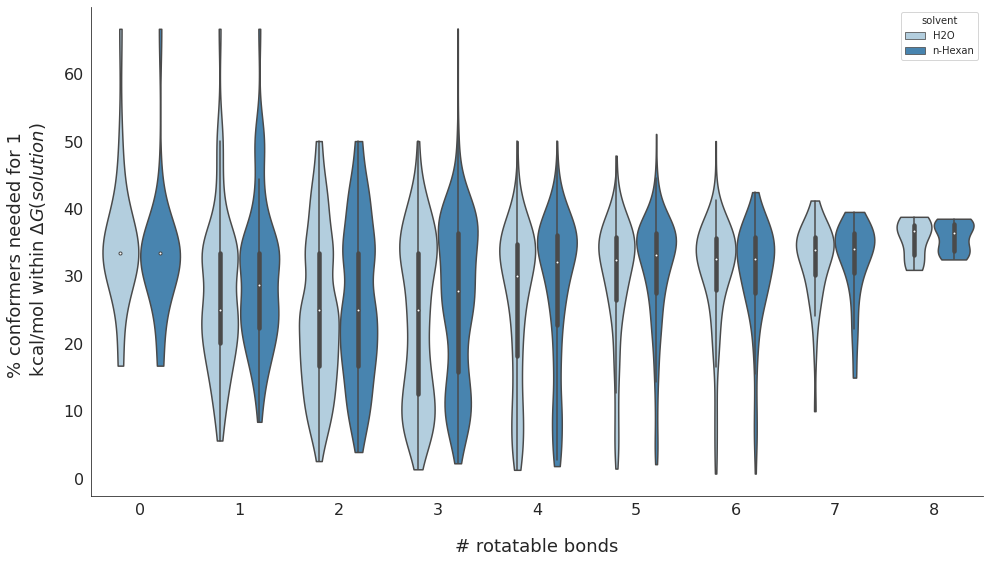

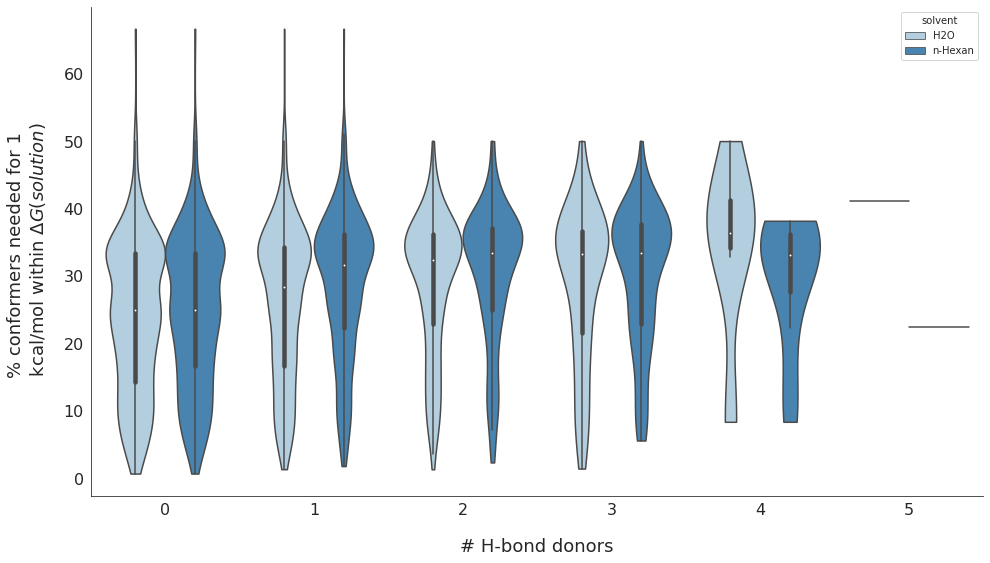

In [476]:
# test solute-level features with water and n-hexanes

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.violinplot(
    data=mol_df[(mol_df["solvent"]=="H2O") | (mol_df["solvent"]=="n-Hexan")],
    x='n_rotatable_bonds',
    y='percent_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette="Blues",
    hue="solvent",
    showfliers=True,
    cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for 1 \n kcal/mol within $\Delta G(solution)$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)




fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.violinplot(
    data=mol_df[(mol_df["solvent"]=="H2O") | (mol_df["solvent"]=="n-Hexan")],
    x='n_hbd',
    y='percent_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette="Blues",
    hue="solvent",
    showfliers=True,
    cut=0,
)

ax1.set_xlabel("# H-bond donors", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for 1 \n kcal/mol within $\Delta G(solution)$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

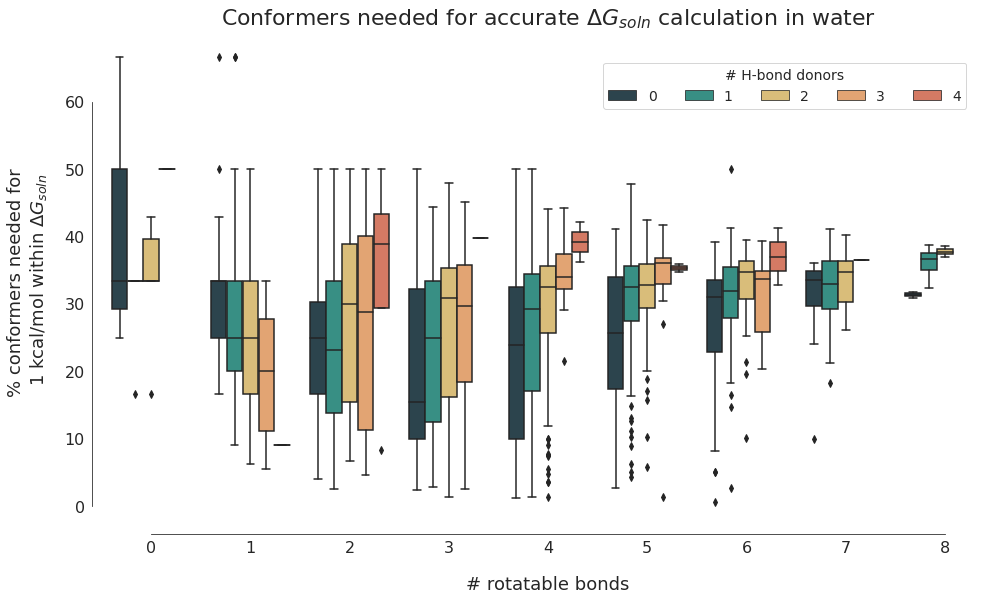

In [566]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='percent_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for \n1 kcal/mol within $\Delta G_{soln}$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper right', borderaxespad=2)

sns.despine(offset=10, trim=True)
ax1.set_title("Conformers needed for accurate $\Delta G_{soln}$ calculation in water", fontsize=22, pad=10)

sns.despine(offset=10, trim=True)

plt.savefig("../exps/plots/percent_confs_needed_water.pdf", bbox_inches="tight")

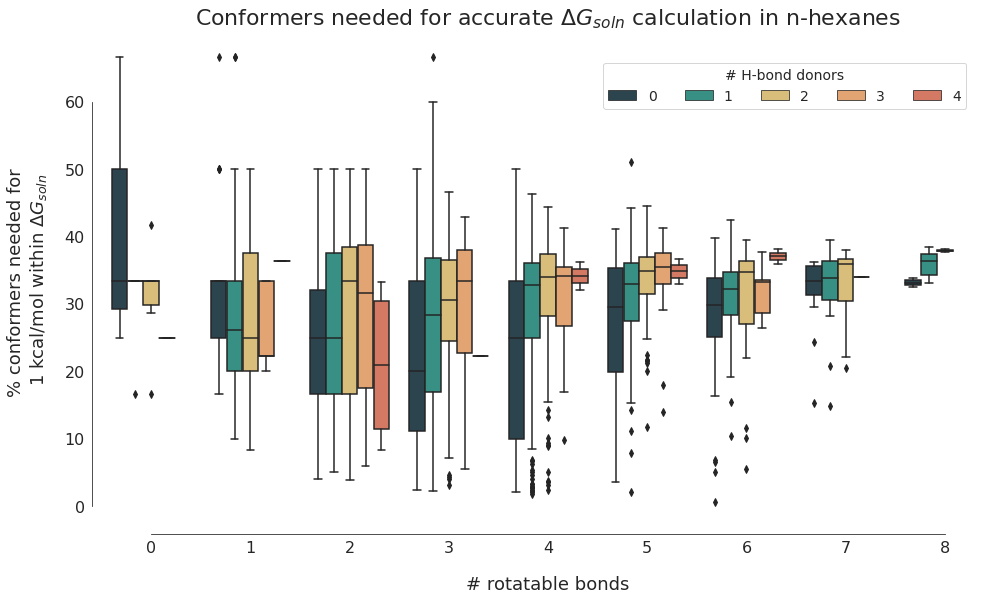

In [567]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="n-Hexan") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='percent_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for \n1 kcal/mol within $\Delta G_{soln}$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper right', borderaxespad=2)

sns.despine(offset=10, trim=True)
ax1.set_title("Conformers needed for accurate $\Delta G_{soln}$ calculation in n-hexanes", fontsize=22, pad=10)

sns.despine(offset=10, trim=True)

plt.savefig("../exps/plots/percent_confs_needed_hexanes.pdf", bbox_inches="tight")

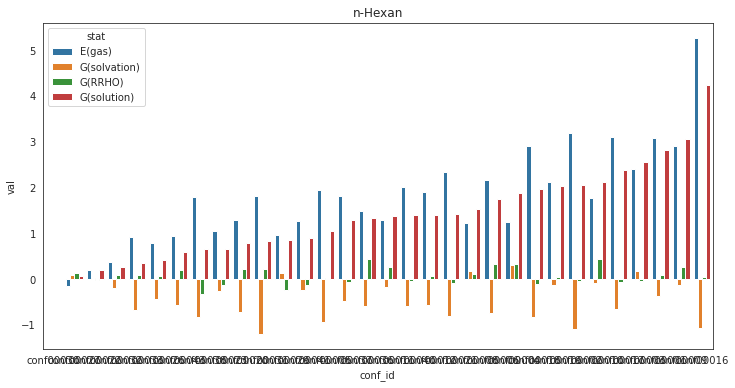

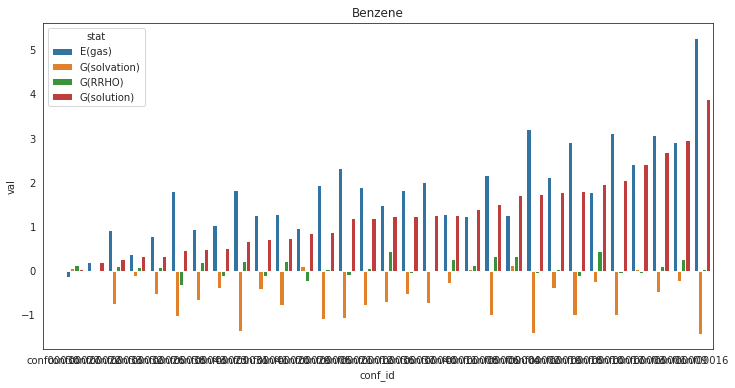

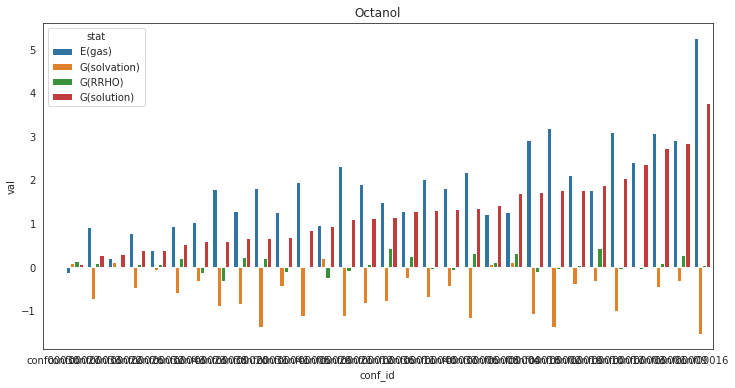

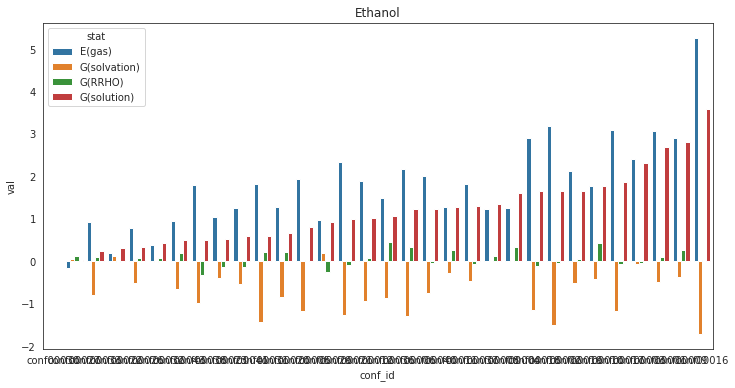

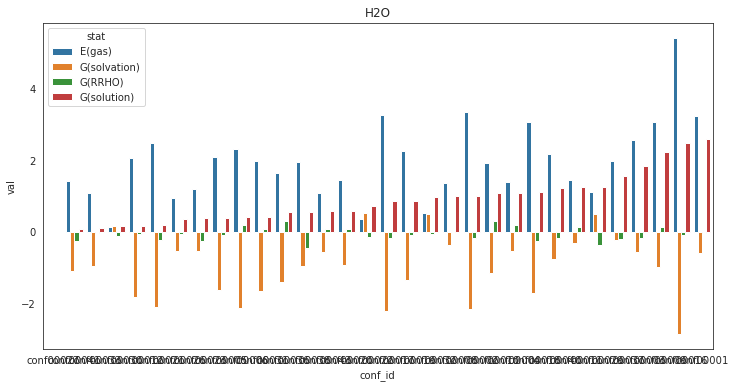

In [267]:
# still need to figure out how to quantify this


q_df = conf_dfs[0]

min_conf_soln = q_df.set_index('conf_id').groupby("solvent")['dG(solution)'].idxmin().sort_index()

lec_soln_components = q_df.set_index(['solvent', 'conf_id']).loc[zip(min_conf_soln.index, min_conf_soln.values)]\
                          .droplevel(level='conf_id').sort_index()[["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"]]

relative_components = q_df.apply(lambda x: x[["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"]] - \
                           lec_soln_components.loc[x["solvent"]], axis=1)
relative_components["solvent"] = q_df["solvent"]
relative_components["conf_id"] = q_df["conf_id"]


representative_solvents = ['n-Hexan', 'Benzene', 'Octanol', 'Ethanol', 'H2O']
for solvent in representative_solvents:


    solvent_relative_components = relative_components[relative_components["solvent"]==solvent]


    fig, ax1 = plt.subplots(figsize=(12, 6))

    sns.barplot(
        data=solvent_relative_components.melt(
            id_vars=["conf_id"],
            value_vars=["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"],
            var_name='stat',
            value_name='val'
        ),
        x='conf_id',
        y='val',
        hue='stat',
        ax=ax1,
    )
    
    ax1.set_title(solvent)

    plt.show()

In [1070]:
def add_mol_properties(test_mol_df):
    
    present_mol_ids = test_mol_df.mol_id.unique()
    mol_id_to_smi_dict = {m_id: id_to_smi.loc[m_id]["canon_smi"] for m_id in present_mol_ids}
    mol_id_to_mol_dict = {m_id: Chem.MolFromSmiles(mol_id_to_smi_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_n_rotatable_bonds = {m_id: AllChem.CalcNumRotatableBonds(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_num_rings = {m_id: AllChem.CalcNumRings(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_n_hbd = {m_id: AllChem.CalcNumHBD(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_n_hba = {m_id: AllChem.CalcNumHBA(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_mol_weight = {m_id: AllChem.CalcExactMolWt(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    
    test_mol_df["solute_smi"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_smi_dict[x])
    test_mol_df["mol"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_mol_dict[x])
    test_mol_df["n_rotatable_bonds"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_n_rotatable_bonds[x])
    test_mol_df["num_rings"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_num_rings[x])
    test_mol_df["n_hbd"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_n_hbd[x])
    test_mol_df["n_hba"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_n_hba[x])
    test_mol_df["mol_weight"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_mol_weight[x])

    bins = [0, 100, 200, 300, 400, 500 ,600]
    test_mol_df["mol_weight_binned"] = pd.cut(test_mol_df["mol_weight"], bins)
    
    return test_mol_df

In [1071]:
relative_components_df = pd.concat(relative_components_list)
relative_components_df = add_mol_properties(relative_components_df)

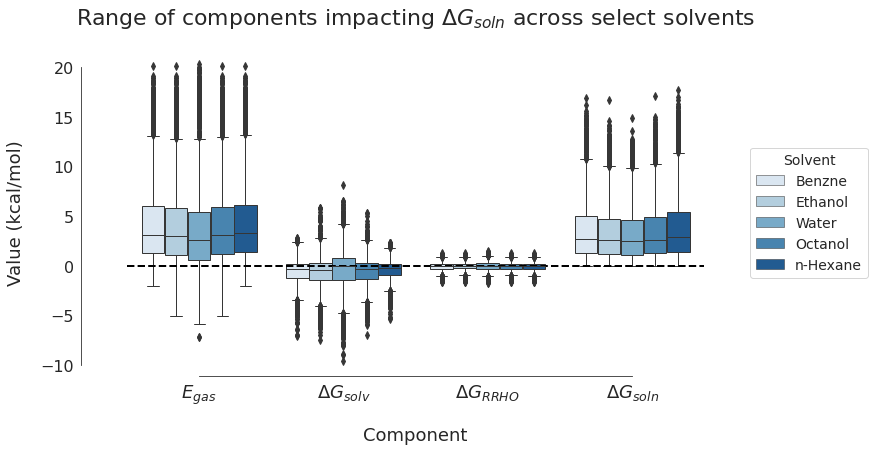

In [1178]:
fig, ax1 = plt.subplots(figsize=(12, 6))

relative_components_solv = relative_components_df[relative_components_df["solvent"].isin(representative_solvents)]
sns.boxplot(
    data=relative_components_solv.melt(id_vars="solvent", \
                                       value_vars=["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"]),
    x='variable',
    y='value',
    hue='solvent',
    palette="Blues",
    showfliers=True,
    linewidth=1,
)

sns.despine(offset=0, trim=True)
ax1.hlines(0, -0.5, 3.5, linewidth=2, linestyle="--", color='black')

ax1.set_xlabel("Component", fontsize=18, labelpad=20)
ax1.set_ylabel("Value (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
handles = ax1.get_legend().legendHandles
ax1.legend(handles=handles, ncol=1, fontsize=14, title="Solvent",  title_fontsize=14, borderaxespad=2,
           labels=["Benzne", "Ethanol", "Water", "Octanol", "n-Hexane"], loc=(1.0, 0.3),)
ax1.set_xticklabels(["$E_{gas}$", "$\Delta G_{solv}$", "$\Delta G_{RRHO}$", "$\Delta G_{soln}$"], \
                     fontsize=18)

ax1.set_title("Range of components impacting $\Delta G_{soln}$ across select solvents", fontsize=22, pad=25)

plt.savefig("../exps/plots/g_soln_components_solvents.pdf", bbox_inches="tight")

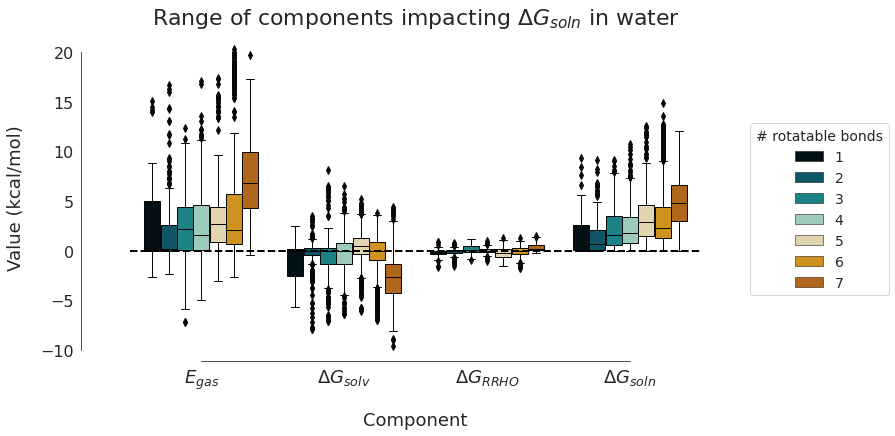

In [1179]:
fig, ax1 = plt.subplots(figsize=(12, 6))

palette = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]
relative_components_water = relative_components_df[relative_components_df["solvent"]=="H2O"]

sns.boxplot(
    data=relative_components_water.melt(id_vars=["solvent", 'n_rotatable_bonds', 'num_rings', 'n_hbd', 'n_hba', \
                                                 'mol_weight', 'mol_weight_binned'], \
                                        value_vars=["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"]),
    x='variable',
    y='value',
    hue='n_rotatable_bonds',
    palette=palette,
    showfliers=True,
    linewidth=1,
)

sns.despine(offset=0, trim=True)
ax1.hlines(0, -0.5, 3.5, linewidth=2, linestyle="--", color='black')

ax1.set_xlabel("Component", fontsize=18, labelpad=20)
ax1.set_ylabel("Value (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
handles = ax1.get_legend().legendHandles
ax1.legend(handles=handles, ncol=1, fontsize=14, title="# rotatable bonds",  title_fontsize=14, borderaxespad=2,
           labels=['1', '2', '3', '4', '5', '6', '7'], loc=(1.0, 0.2),)
ax1.set_xticklabels(["$E_{gas}$", "$\Delta G_{solv}$", "$\Delta G_{RRHO}$", "$\Delta G_{soln}$"], \
                     fontsize=18)

ax1.set_title("Range of components impacting $\Delta G_{soln}$ in water", fontsize=22, pad=10)

plt.savefig("../exps/plots/g_soln_components_rotatable_bonds.pdf", bbox_inches="tight")

### what is the effect of conformers when compared to lowest energy conformer in solution
dG(soln)_0 will be strictly smaller than the boltzmann-averaged dG(soln)

should check this among many solute/solvent splits

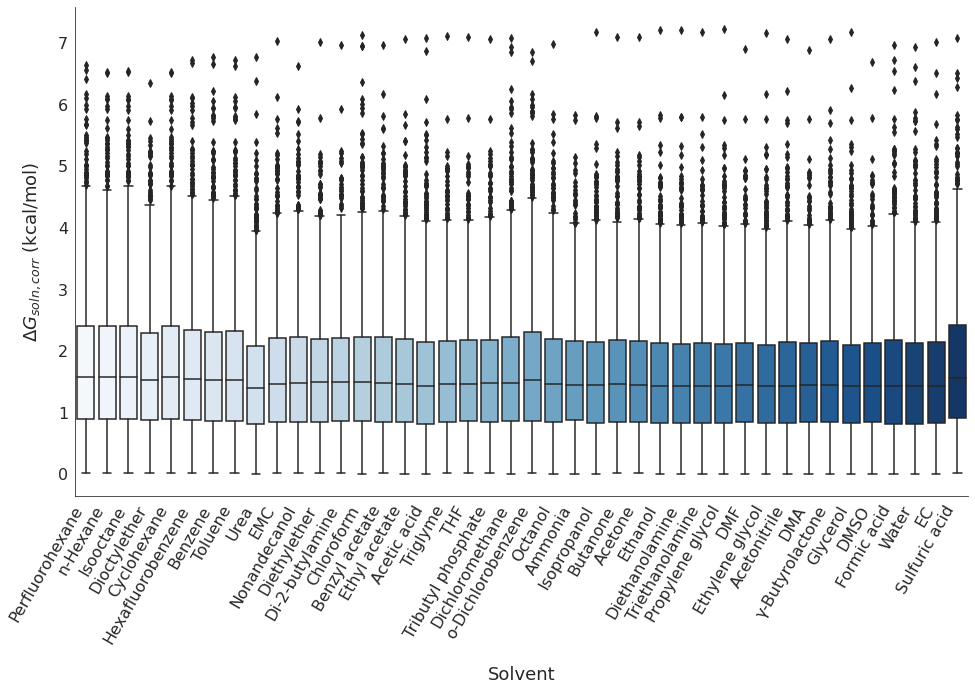

In [496]:
# first, across all solvents indiscriminate of solutes

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=mol_df,
    x='solvent',
    y='corr_lec_soln_abs',
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

plt.savefig("../exps/plots/g_corr_per_solvent.pdf", bbox_inches="tight")

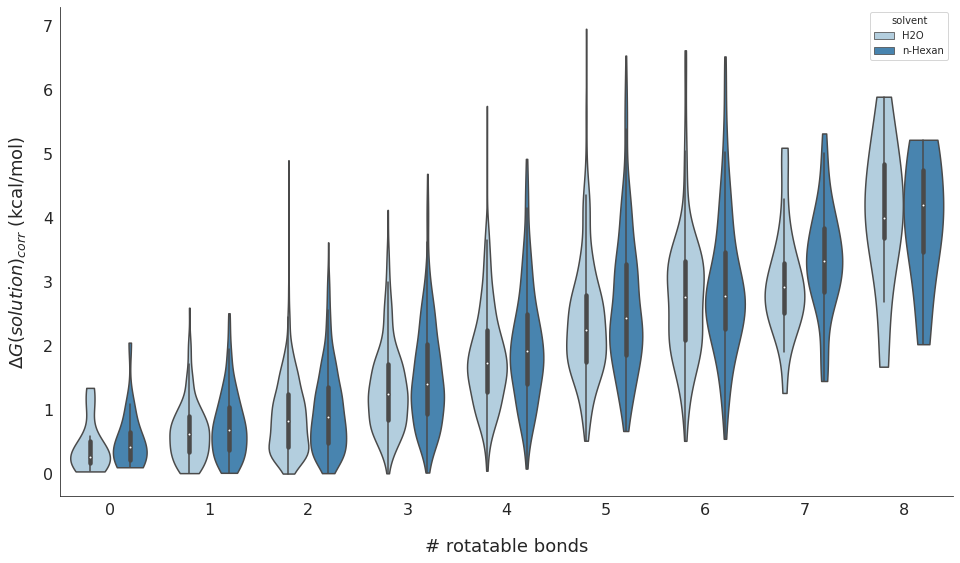

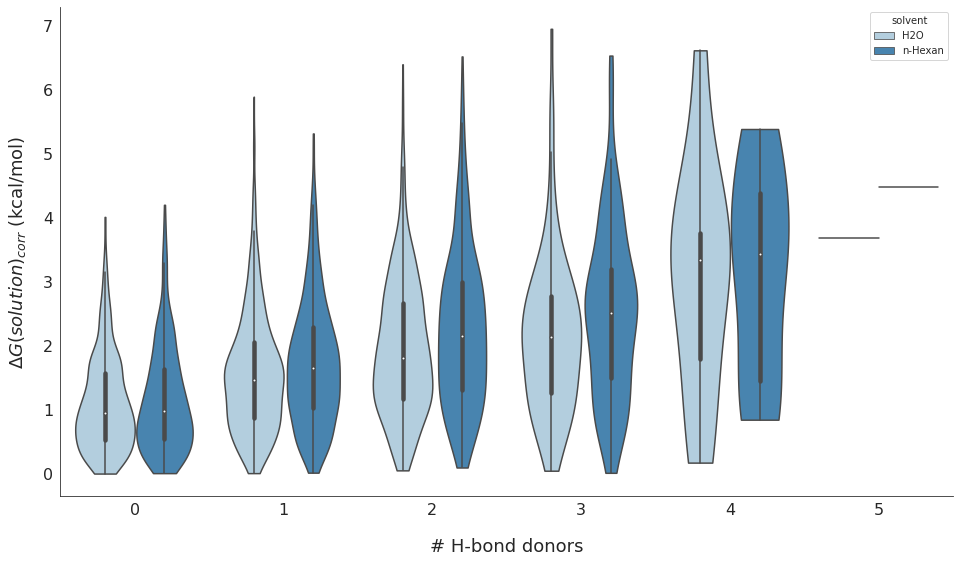

In [96]:
# test solute-level features with water and n-hexanes

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.violinplot(
    data=mol_df[(mol_df["solvent"]=="H2O") | (mol_df["solvent"]=="n-Hexan")],
    x='n_rotatable_bonds',
    y='corr_lec_soln_abs',
    ax=ax1,
    palette="Blues",
    hue="solvent",
    showfliers=True,
    cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G(solution)_{corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)




fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.violinplot(
    data=mol_df[(mol_df["solvent"]=="H2O") | (mol_df["solvent"]=="n-Hexan")],
    x='n_hbd',
    y='corr_lec_soln_abs',
    ax=ax1,
    palette="Blues",
    hue="solvent",
    showfliers=True,
    cut=0,
)

ax1.set_xlabel("# H-bond donors", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G(solution)_{corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

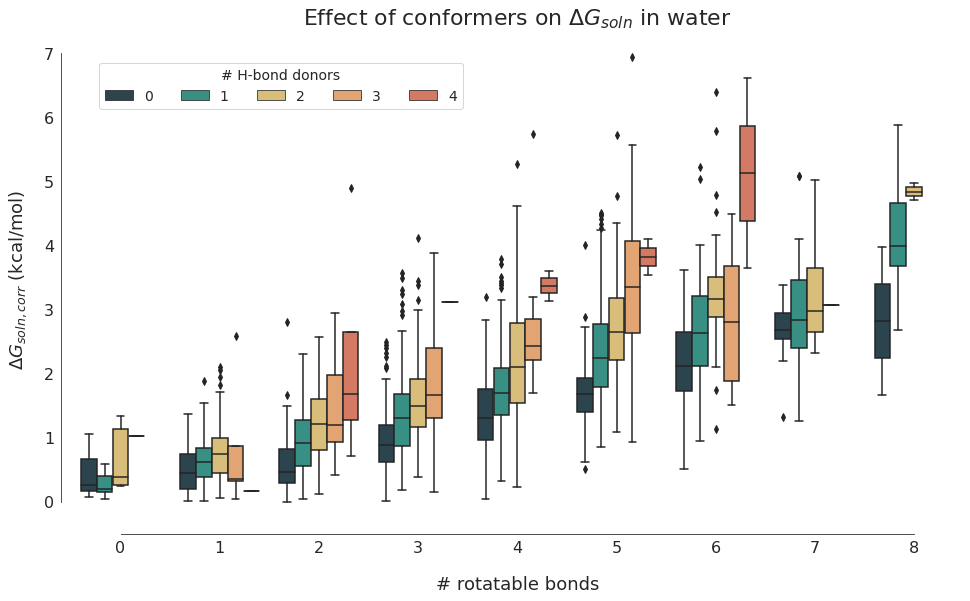

In [553]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='corr_lec_soln_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

sns.despine(offset=10, trim=True)
ax1.set_title("Effect of conformers on $\Delta G_{soln}$ in water", fontsize=22, pad=10)

plt.savefig("../exps/plots/g_soln_corr_water.pdf", bbox_inches="tight")

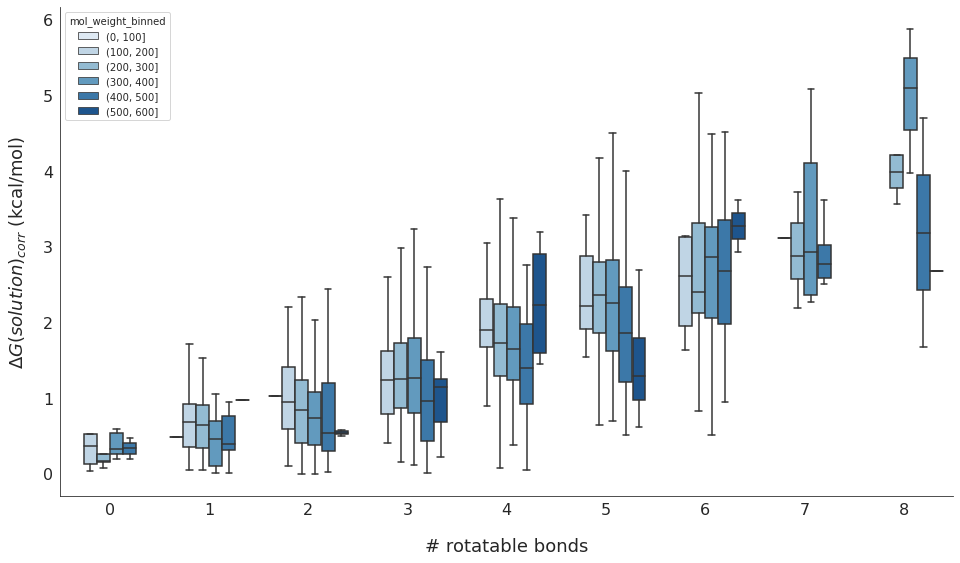

In [510]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='corr_lec_soln_abs',
    ax=ax1,
    palette="Blues",
    hue="mol_weight_binned",
    showfliers=False,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G(solution)_{corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

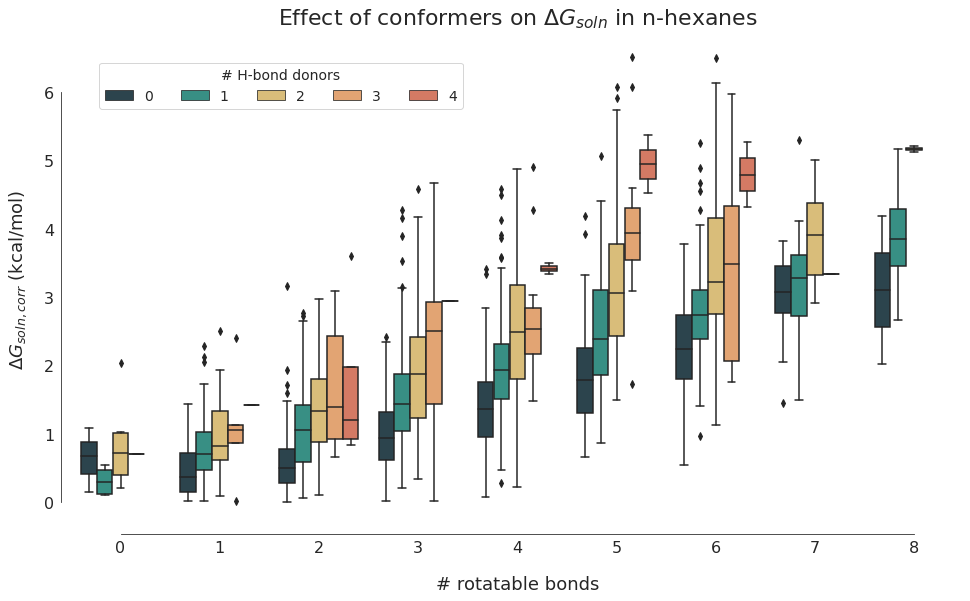

In [554]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="n-Hexan") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='corr_lec_soln_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

sns.despine(offset=10, trim=True)
ax1.set_title("Effect of conformers on $\Delta G_{soln}$ in n-hexanes", fontsize=22, pad=10)

plt.savefig("../exps/plots/g_soln_corr_hexanes.pdf", bbox_inches="tight")

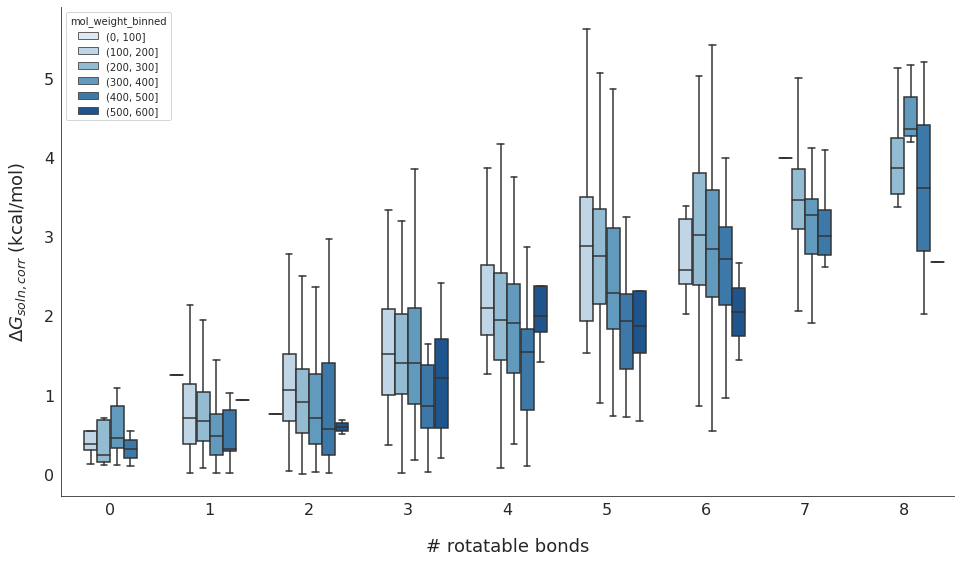

In [502]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="n-Hexan") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='corr_lec_soln_abs',
    ax=ax1,
    palette="Blues",
    hue="mol_weight_binned",
    showfliers=False,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

In [ ]:
# how many conformers do we need to get within 1 kcal/mol of the true value?
# should check if this changes across solutes/solvents

In [ ]:
# distributions of each E(gas) and G(RRHO)

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.violinplot(
    data=conf_df.melt(value_vars=['E(gas)', 'G(RRHO)'], var_name='stat', value_name='val'),
    x='stat',
    y='val',
    ax=ax1,
    palette="Blues",
    showfliers=True,
)

In [ ]:
# G(solvation)

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=conf_df,
    x='solvent',
    y='G(solvation)',
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=False,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G(solvation)$ (kJ/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

In [ ]:
((conf_df[conf_df["solvent"]=="H2O"]["corr_lec_gas"] - conf_df[conf_df["solvent"]=="H2O"]["corr_lec_gas_solv"]) == 0).mean()

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

conf_df_long = conf_df.melt(id_vars=['solvent', 'num_rings', 'n_hbd', 'n_hba', 'n_rotatable_bonds'],
                            value_vars=["corr_lec_gas", "corr_lec_gas_solv", "corr_boltz_gas_solv"],
                            var_name='stat', value_name='val')

sns.boxplot(
    data=conf_df_long[conf_df_long["solvent"]=="H2SO4"],
    x='stat',
    y='val',
    hue='n_rotatable_bonds',
    ax=ax1,
    palette="Blues",
    showfliers=False,
)

ax1.set_xlim(-0.5, 2.5)
plt.hlines(0, xmin=-0.5, xmax=2.5)

ax1.get_legend().remove()

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

conf_df_long = conf_df.melt(id_vars=['solvent', 'num_rings', 'n_hbd', 'n_hba', 'n_rotatable_bonds'],
                            value_vars=["corr_lec_gas", "corr_lec_gas_solv", "corr_boltz_gas_solv"],
                            var_name='stat', value_name='val')

sns.boxplot(
    data=conf_df_long[(conf_df_long["solvent"]=="H2O")],
    x='stat',
    y='val',
    hue='n_rotatable_bonds',
    ax=ax1,
    palette="Blues",
    showfliers=False,
)

ax1.set_xlim(-0.5, 2.5)
plt.hlines(0, xmin=-0.5, xmax=2.5)

ax1.get_legend().remove()

In [ ]:
def calc_energy(gas_e, solv, rrho):
    g_soln = [a+b+c for a,b,c in zip(gas_e, solv, rrho)]

    boltz_ = [np.exp(-e/(R*T)) for e in g_soln]
    boltz = [x/sum(boltz_) for x in boltz_]

    return sum([x*y for x,y in zip(g_soln, boltz)])


gas_e = [-1, -2, 0]
solv = [-4, -2, -2]
rrho = [0, 0, 0]
print(calc_energy(gas_e, solv, rrho))

gas_e = [-1, -2, -1.5]
solv = [-4, -2, -3]
rrho = [0, 0, 0]
print(calc_energy(gas_e, solv, rrho))

gas_e = [-1, -2, -1.2]
solv = [-4, -2, -3]
rrho = [0, 0, 0]
print(calc_energy(gas_e, solv, rrho))

gas_e = [-1, -2, -1.7]
solv = [-4, -2, -3]
rrho = [0, 0, 0]
print(calc_energy(gas_e, solv, rrho))

gas_e = [-1, -2, -1.7]
solv = [-7, -2, -3]
rrho = [0, 0, 0]
print(calc_energy(gas_e, solv, rrho))

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=conf_df_long[conf_df_long["solvent"]=="n-Hexan"],
    x='stat',
    y='val',
    hue='n_rotatable_bonds',
    ax=ax1,
    palette="Blues",
    showfliers=False,
)

ax1.set_xlim(-0.5, 2.5)
plt.hlines(0, xmin=-0.5, xmax=2.5)

ax1.get_legend().remove()

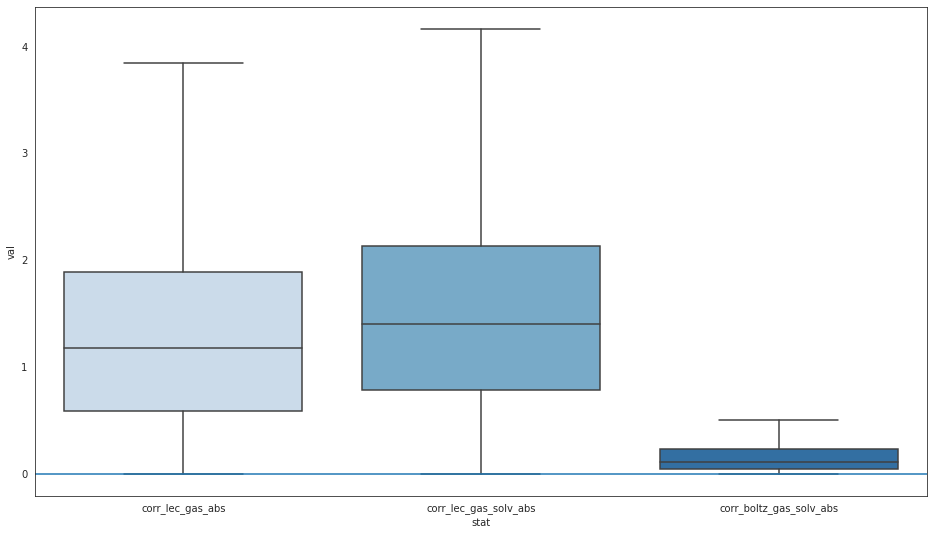

In [112]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=mol_df.melt(id_vars=['solvent'],
                      value_vars=["corr_lec_gas_abs", "corr_lec_gas_solv_abs", "corr_boltz_gas_solv_abs"],
                      var_name='stat', value_name='val'),
    x='stat',
    y='val',
#     hue='solvent',
    ax=ax1,
    palette="Blues",
    showfliers=False,
)

ax1.set_xlim(-0.5, 2.5)
plt.hlines(0, xmin=-0.5, xmax=2.5)

In [493]:
# order data based on dielectric coefficient
ordered_dielectric_from_name = [dielectric_dict[s] for s in solvent_names]
dielectric_order = np.argsort(ordered_dielectric_from_name)
dielectric_ordering_solvents = ['Gas'] + [solvent_names[i] for i in dielectric_order]
reshaped_agreement = agreement[dielectric_order][:, dielectric_order]

# add column for gas agreement
agreement_data_ = np.vstack([np.expand_dims(gas_agreement, 0), reshaped_agreement])
gas_agreement_ = np.expand_dims(np.concatenate([np.array([100]), gas_agreement]), 1)
agreement_data = np.hstack([gas_agreement_, agreement_data_])

lower_triangular_heatmap(
    agreement_data,
    dielectric_ordering_solvents,
    dielectric_ordering_solvents,
    hide_diags=True,
)

# plt.savefig("../exps/plots/lowest_energy_conf_agreement.pdf", bbox_inches="tight")

KeyError: 'Acetic acid'

In [ ]:
# order data based on dielectric coefficient
reshaped_dG_solution_dG_solution_pr = dG_solution_dG_solution_pr[dielectric_order][:, dielectric_order]

# add column for gas agreement
sp_data_ = np.vstack([np.expand_dims(dE_gas_dG_solution_pr[0], 0), reshaped_dG_solution_dG_solution_pr])
gas_sp_ = np.expand_dims(np.concatenate([np.array([1.]), dE_gas_dG_solution_pr[0]]), 1)
sp_data = np.hstack([gas_sp_, sp_data_])

lower_triangular_heatmap(
    sp_data,
    dielectric_ordering_solvents,
    dielectric_ordering_solvents,
    annot_fmt=".2f",
    annot_size=10,
    cbar_title=r"Spearman $\rho$",
    hide_diags=True,
)

plt.savefig("../exps/plots/solvent_spearman.pdf", bbox_inches="tight")

In [113]:
agree_data_df = pd.DataFrame({
    'solvent': sorted(solvent_names)*len(gas_agreement),
    'gas_agreement': np.stack(gas_agreement).ravel(),
    'rrho_agreement': np.stack(rrho_agreement).ravel(),
})

ordered_solvents = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]
agree_data_df['solvent_class'] = agree_data_df['solvent'].apply(lambda x: solvent_class_dict[x])

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.barplot(
    data=agree_data_df,
    x="solvent",
    y="gas_agreement",
    ax=ax1,
    order=ordered_solvents,
    palette="Blues",
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

# plt.savefig("../exps/plots/g_corr_per_solvent.pdf", bbox_inches="tight")

ValueError: need at least one array to stack

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.barplot(
    data=agree_data_df,
    x="solvent",
    y="rrho_agreement",
    ax=ax1,
    order=ordered_solvents,
    palette="Blues",
)

ax1.set_ylim(0.6, 0.8)
ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

# plt.savefig("../exps/plots/g_corr_per_solvent.pdf", bbox_inches="tight")

In [ ]:
g_data_df

In [ ]:
diff = []
for i in range(len(conf_g_correction)):
    diff.append(np.max(conf_g_correction[i]) - np.min(conf_g_correction[i]))

plt.hist(diff)

In [ ]:
g_data_df

In [ ]:
sns.scatterplot(
    data=g_data_df[g_data_df["solvent"]=="H2O"],
    x="n_confs",
    y="conf_g_correction",
    palette="Blues",
)

In [ ]:
q_data_df = pd.DataFrame({
    'solvent': sorted(solvent_names)*len(n_confs_total),
    'n_confs': np.stack(n_confs_total).ravel(),
    'n_confs_min': np.stack(n_confs_min_for_q).ravel(),
})

q_data_df['percent_confs_needed'] = q_data_df['n_confs_min'] / q_data_df['n_confs'] * 100
q_data_df['solvent_class'] = g_data_df['solvent'].apply(lambda x: solvent_class_dict[x])


fig, ax1 = plt.subplots(figsize=(16, 5))
sns.set_style("white")

sns.boxplot(
    data=q_data_df,
    x="solvent",
    y="percent_confs_needed",
    ax=ax1,
    order=ordered_solvents,
    palette="Blues",
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=16)

In [ ]:
from scipy.optimize import curve_fit

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

def func(x, a, c, d):
    return a*np.exp(-c*x)+d

xs, ys = [], []
for s in tqdm(solvents):
    
    # log norm the x data
    x = np.log(q_data_df[q_data_df['solvent']==s]["n_confs"].values)
    
    # fit params to exponential fit
    popt, pcov = curve_fit(func, x, q_data_df[q_data_df['solvent']==s]["percent_confs_needed"].values, 
                           p0=(1, 1e-6, 1))
    
    # apply params to fit and get y
    y = func(q_data_df[q_data_df['solvent']==s]["n_confs"].values, *popt)
    
    # plot unnormalized version on log scale
    sns.lineplot(
        x=np.exp(x),
        y=y,
        label=s,
        ax=ax1,
    )
    
ax1.set_xlabel("N conformers", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=10)
    
plt.xscale('log')
plt.show()

In [ ]:
len(solvent_names)

In [ ]:
gas_agreement_df = pd.DataFrame({
    'solvent': solvents.tolist()*len(gas_agreement),
    'gas_agreement': np.stack(gas_agreement).ravel(),
})


fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.barplot(
    data=gas_agreement_df,
    x='solvent',
    y='gas_agreement',
    ax=ax1,
    palette="Blues",
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("% agreement of lowest energy conformer in gas phase", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=16)

In [ ]:
lower_triangular_heatmap(dG_solution_dG_solution_pr, solvents, solvents, annot_fmt=".2f", cbar_title="Spearman")

In [ ]:
dE_gas_dG_solution_pr[0]

In [ ]:
dE_gas_dG_solv_pr[0]

In [ ]:
dE_gas_dG_rrho_pr[0]

In [ ]:
from rdkit import Chem
Chem.MolFromSmiles('CCOC(=O)OC')